# Overseeing government with AI - ICEDEG 2023 tutorial


Copyright (C) 2023  [Henrique S. Xavier](https://github.com/hsxavier)

This notebook is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This notebook is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this notebook.  If not, see <https://www.gnu.org/licenses/>.


## 1. The goal of the tutorial

Overseeing government may demand a lot of work. Monitoring the Brazilian Government Gazette in search of high impact decisions, for instance, requires reading many hundreds of legal notices every day. In this scenario, a filtering tool that select potentially relevant notices for human scrutiny might come in handy. This tutorial goes through the process of creating such a tool using machine learning, and is based on a successful implementation made by the Brazilian Congress since 2020.

**Outline**

* Cover some basics of Machine Learning that will come about in the tutorial
* Develop a simpler (bag-of-words) model for the ranking and filtering of notices
* Develop an advanced (BERT) model

Suggested reference: [Pretrained transformers for text ranking: Bert and beyond](https://arxiv.org/abs/2010.06467) (Lin, Nogueira & Yates, 2021)

### 1.1 Setting the stage

The cell below retrieve necerrary code for the tutorial and sets up the stage if you are running this notebook in Google colab.

In [55]:
import os
from importlib.util import find_spec

# Get auxiliary code if not present:
xavy_spec = find_spec('xavy')
if xavy_spec is None:
    print('Cloning xavy package...')
    !git clone https://github.com/hsxavier/xavy

# Download auxiliary code and setup paths:
if os.getenv("COLAB_RELEASE_TAG"):
    print('Cloning tutorial repo...')
    !git clone https://github.com/cewebbr/text_ranking_in_gov.git
    print('Creating symlinks...')
    !ln -s text_ranking_in_gov/imagens ./imagens
    !ln -s text_ranking_in_gov/data ./data
    !ln -s text_ranking_in_gov/modelos ./modelos
    !ln -s text_ranking_in_gov/analysis/auxiliary.py
    !ln -s text_ranking_in_gov/analysis/neural_aux.py
    !ln -s text_ranking_in_gov/analysis/dou_sorter_common_functions.py
    !ln -s text_ranking_in_gov/analysis/dou_model_eval.py

## 2. Machine Learning basics

Apart from packages for plotting and for numerical computations, we will use the machine leaning package **scikit-learn**.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import auxiliary as aux

### 2.1. Simple examples of machine learning problems

#### 2.1.1. Binary classification (yes/no): is this mango tasty?

Pretend we are trying to learn to guess if a mango is tasty or not based on its color and consistency. We will measure the color and the consistency in scales from 0 to 1. The actual tastyness is defined by the function below:

In [8]:
def tastyness(color, consist, noise=0):
    """
    Return 0 or 1 if a mango is tasty or not according
    to its color and consistency. The introduction of
    noise makes the relation a bit fuzzy (intrinsically
    uncertain).47
    """
    
    # Generate intrinsic noise, if any:
    rng = np.random.default_rng()
    e = noise * rng.normal(size=(4, len(color)))
    
    # Decide whether the mango is trully tasty or not:
    tasty = ((color + e[0] > 0.2) & (color + e[1] < 0.8) & (consist + e[2] > 0.3) & (consist + e[3] < 0.7)).astype(int)
    
    return tasty

To learn about this relation between tastyness and color and consistency, we select a sample of mangos _that is representative of the mangos we will find later on_:

In [30]:
# Reset simulation with given parameters:
n_samples = 30
seed = 45864
intrinsic = 0.0  # You can try 0.05, for instance.

# Record the first generated data:
rng = np.random.default_rng(seed)
x   = rng.random(n_samples)
y   = rng.random(n_samples)
z   = tastyness(x, y, intrinsic)
xp  = x[z == 1]
yp  = y[z == 1]
xn  = x[z == 0]
yn  = y[z == 0]
rng = np.random.default_rng(seed)

The code below selects a set of mangos. Each time you run it, you are selecting another (and different) set.

In [31]:
# Generate data sample:
color1   = rng.random(n_samples)
consist1 = rng.random(n_samples)
tasty1   = tastyness(color1, consist1, intrinsic)

Below, we create a scatter plot of the mangos, where the color of the points tell if the mango is tasty or not (assume that orange means tasty). We also draw a boundary that we use to discriminate the good from the bad mangos, _guessed from the first set of 30 mangos we see_. You may select five different boundaries, _all of which perfectly splits the first set of analyzed mangos into tasty and not tasty_. However, if we select a new set of mangos, the success of each boundary is different.

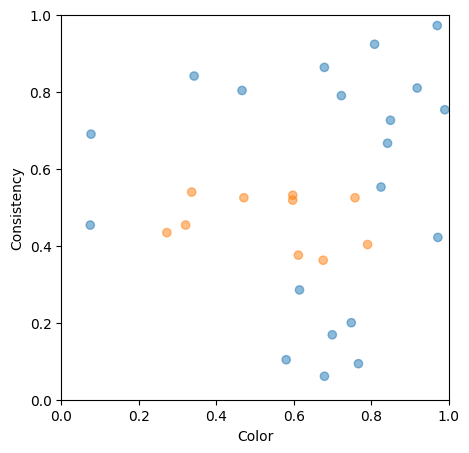

In [32]:
# Plot data:
cmap = pl.get_cmap('tab10')
pl.figure(figsize=(5,5))
pl.scatter(color1, consist1, alpha=0.5, color=cmap(tasty1))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('Color')
pl.ylabel('Consistency')
ax = pl.gca()

# Draw decision boundary (choose one):
guess = None
#guess = PatchCollection([patches.Rectangle((0.25, 0.35), 0.55, 0.2)], edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection([patches.Rectangle((0.09, 0.3), 0.72, 0.48)], edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection([patches.Ellipse((0.5, 0.5), 0.7, 0.35, angle=-15)], edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection(aux.multicircles(xp, yp), edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection(aux.multicircles(xn, yn), edgecolor='r', linestyle='--', facecolor='none')
if guess is not None:
    ax.add_collection(guess)

pl.show()

Do the following experiments, combining them in multiple ways:

* Try **selecting a new set of mangos** and seeing how our boundary discriminates good and bad mangos.
* Try **changing the decision boundary** for identifying tasty mangos. How does this affect the two errors (false positives and false negatives)?
* Try **increasing the sample size** and seeing if you can better see the pattern in mango tastiness.
* Try **adding intrinsic noise** to the relation between tastyness and color and consistency. Would you be able to set a boundary that perfectly splits the mangos into good and bad?

#### 2.1.2. Regression (predict values): number of active users at a given time of the day

Suppose we want the predict the number of active users on an online platform according to the time of the day. 
The actual number of users at a given time depends on many other factors we cannot measure; therefore, it is treated 
as a random number that fluctuates around the expected value given by the function below.

In [33]:
def active_users(hour):
    """
    Compute the expected number of active users per time 
    of the day (hour from 0 to 24).
    """  
    x = hour
    y = (np.sin(2*np.pi / 24 * 3 * (x - 5)) - 0.015 * (x - 12)**2 + 4 * np.exp(-(x-20)**2*0.4) + 3) * 15

    return y

We are busy people, so we cannot keep an eye on the number of users all the time. To learn about the relation above, we go through a week collecting data when we can (at random times) by writing down the time of the day and the number of active people. The code below defines the amount of data collected each week.

In [60]:
# Reset simulation with given parameters:
n_samples = 32
seed      = 363

# Record the first data that will be generated:
rng = np.random.default_rng(seed)
x0  = rng.random(n_samples) * 24
y0  = rng.poisson(active_users(x0))
rng = np.random.default_rng(seed)

This data is generated by the code below. Each time we run it is another week we collected new data (starting with the first week):

In [71]:
# Generate data sample:
hour  = rng.random(n_samples) * 24
#hour  = np.linspace(0,24, n_samples)
users = rng.poisson(active_users(hour))

To the dataset collected in the first week, we fit a polynomial model with a degree that we can choose. By increasing the polynomial degree, 
we can make the model reproduce [almost any function](https://en.wikipedia.org/wiki/Taylor_series). Thus, in this way, the model can become more and more flexible (complex).

In [63]:
# Fit model to the first data:
degree = 13
model = Pipeline([('poly', PolynomialFeatures(degree)), ('scal', StandardScaler()), ('reg', LinearRegression())])
dump = model.fit(np.transpose([x0]), y0)

The plot below shows the data collected in the first week (in empty pink circles), the last dataset collected (blue filled circles) and the polynomial model fitted to the data from the first week (red line). In text, it is also shown the model's average error (RMSE) computed for the first dataset (used to fit the model) and for the last data collected.

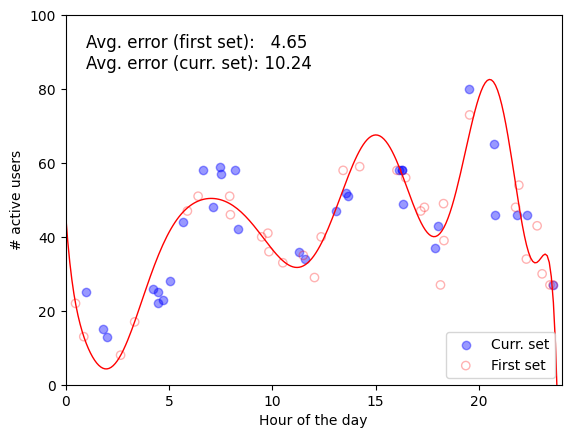

In [72]:
# Plot the first dataset and the last data collected:
pl.scatter(hour, users, color='b', alpha=0.4, label='Curr. set')
pl.scatter(x0, y0, edgecolor='r', facecolor='none', alpha=0.3, label='First set')

# Drawn curve representing the fit:
x_fit = np.arange(0, 24, 0.1)
y_fit = model.predict(np.transpose([x_fit]))
pl.plot(x_fit, y_fit, color='r', linewidth=1)

# Compute the error on the first data:
y0_pred = model.predict(np.transpose([x0]))
err0 = mean_squared_error(y0, y0_pred, squared=False)
# Compute the error on the new data:
pred_users = model.predict(np.transpose([hour]))
err_pred = mean_squared_error(users, pred_users, squared=False)
# Show the errors:
pl.text(1, 80, 'Avg. error (first set):  {:5.2f}\nAvg. error (curr. set): {:5.2f}\n'.format(err0, err_pred), ha='left', fontsize=12)

# Format the plot:
pl.xlim([0,24])
pl.ylim([0, 100])
pl.xlabel('Hour of the day')
pl.ylabel('# active users')
pl.legend(loc='lower right')
pl.show()

Do the following experiments, combining them in multiple ways:

* **Collect new data.** How does the model's predictions compare to the data used to fit it? And to the new data? Remember that the prediction error is measured by the vertical distance between the datapoint and the line. Check the average error as well.
* **Change the model's flexibility** by changing the polynomial degree. Does this improve the model's fit to the first data? What about to the new data (not used to train the model)?
* **Change the amount of collected data**. How does this affect the model and its performance on the seen and unseen data?

The code below fits polynomial models with different flexibilities to the training data and tests it on both datasets generated above. The results are shown in a plot. It should reflects our findings from the experiments made above.

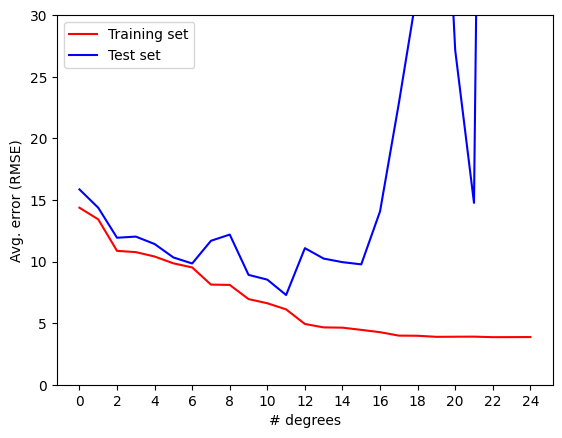

In [73]:
train_rmse = []
test_rmse  = []
max_deg    = min(n_samples, 25)
deg_list   = list(range(0, max_deg))
for deg in deg_list:
    
    # Instantiate model with a given polynomial degree and fit to the training (first) data:
    m = Pipeline([('poly', PolynomialFeatures(deg)), ('scal', StandardScaler()), ('reg', LinearRegression())])
    m.fit(np.transpose([x0]), y0)
    
    # Compute error for the training data:
    y_pred = m.predict(np.transpose([x0]))
    err = mean_squared_error(y0, y_pred, squared=False)
    train_rmse.append(err)
    
    # Compute error for the test (new) data:
    y_pred = m.predict(np.transpose([hour]))
    err = mean_squared_error(users, y_pred, squared=False)
    test_rmse.append(err)

pl.plot(deg_list, train_rmse, color='r', label='Training set')
pl.plot(deg_list, test_rmse, color='b', label='Test set')
pl.ylim([0, 30])
pl.xticks(range(0, max_deg, 2))
pl.xlabel('# degrees')
pl.ylabel('Avg. error (RMSE)')
pl.legend()
pl.show()

#### Takeaway messages

**Main ones**
* An increase in the model's flexibility (almost) always leads to a smaller error on the training set.
* An increase in model's flexibility (complexity) leads to more variance (chance of overfitting): the model may have trouble generalizing.
* A decrease, on the contrary, leads to more bias (chance of underfitting): the model cannot learn all there is to be learned.
* More data leads to more information and less variance: we can use more complex models.
* We are looking for the sweet spot where the error on the unseen data is minimum.
* The choice of a sweet spot based on previously unseen data makes it "seen", so the average error estimate is overconfident.
* In the end will use three distinct datasets: training, validation and test sets.

**Extras**
* There are irreducible errors, intrinsic to the data, that limit the perfomance of the model.
* Adding data features acts in a similar way to increasing the flexibility of the model. 
* Different classes of models have different limitations, some might work better than others.

### 2.2. Splitting the data into disjoint sets

In [12]:
from sklearn.svm import SVC

As seen in Section 2.1, ML models can underfit or overfit the data. By comparing the performance on data used to fit the model with the performance on unseen data, we can know in which regime we are. Moreover, since it is the latter performance we are interested in, it can be used to choose the best hyperparameters for the job (in Section 2.1.1, the shape of the decision boundary; and in Section 2.1.2, the degree of the polynomial). This is called **hyperparameter tuning** or **fine tuning**.

Thus, when building an ML model, it is important to split the data into two disjoint datasets, one for fitting (training) the model and another for hyperparameter tuning. Note, however, that, in this situation, the last dataset is not "unseen" anymore: the perfomance of the model on it was used as input for determining the hyperparemeters, which may cause a slight overfit on it. Therefore, it is common practice to split the data into three disjoint datasets:

* **Training set** - Used to fit the model; should be around 70% of the data.
* **Validation set** - Used to improve the model through hyperparameter tuning; should be around 15% of the data.
* **Test set** - Locked in a vault! Only used to get an unbiased measure of the performance when the model is done; should be around 15% of the data.

#### 2.2.1. Problems caused by bad sampling (or splitting) of the dataset

Let's generate some mango data and try some splits.

**Important:** all splits of the dataset above should be representative of the population (i.e. the difference between their target variables should come mostly from noise, that is, from variations that are not predictable by the model), and they should be dispersed all over the feature space (extrapolations are bad). The most common way to achieve this is by random sampling the data.

In [13]:
# Gata generation parameters:
seed       = None
n_samples  = 1200
noise      = 0.08
train_frac = 0.6

# Generate the full dataset:
rng = np.random.default_rng(seed)
color   = rng.random(n_samples)
consist = rng.random(n_samples)
tasty   = tastyness(color, consist, noise) # We did not specify a seed for the noise.

Below we select a subsample of the dataset (e.g. for training the model). 

This first selection is done correctly: the probability that a mango is selected does not depend on any of its properties:

In [14]:
# Unbiased selection - the probability that a mango is selected does not depend on its tastyness:
unbiased_features, unbiased_tasty = aux.biased_random_split((color, consist), tasty, train_frac, 0.0, rng)
unbiased_color, unbiased_consist  = unbiased_features

Probability of adding instance to training set, according to its target label:
label == 1: 60.0%;   label == 0: 60.0%


This next selection, however, favors mangos that are good (which is wrong):

In [15]:
# Biased selection - good mangos are more likely to get selected:
biased_features, biased_tasty = aux.biased_random_split((color, consist), tasty, train_frac, 1.0, rng)
biased_color, biased_consist  = biased_features

Probability of adding instance to training set, according to its target label:
label == 1: 97.9%;   label == 0: 48.9%


Now we compare these two selections with the original dataset and with another wrong selection (that does not cover the whole feature space):

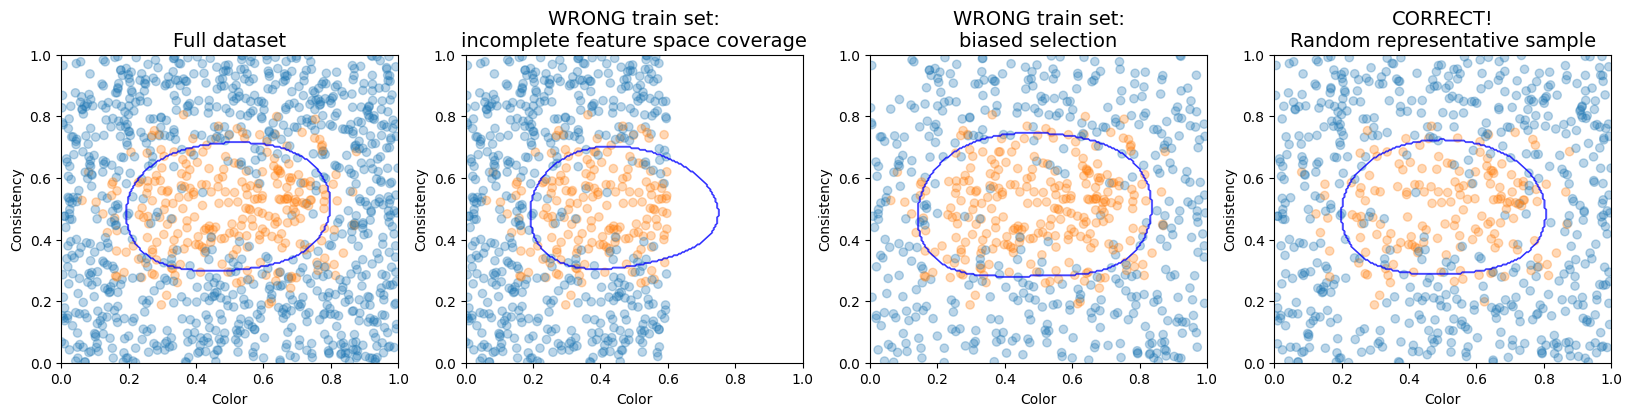

In [16]:
# Set colors and model for drawing the decision boundary:
cmap = pl.get_cmap('tab10')
colors = np.array([cmap(i) for i in tasty])
svc = SVC()

# Data for each plot:
xs = [color, color[color < train_frac], biased_color, unbiased_color]
ys = [consist, consist[color < train_frac], biased_consist, unbiased_consist]
ks = [tasty, tasty[color < train_frac], biased_tasty, unbiased_tasty]
titles = ['Full dataset', 'WRONG train set:\nincomplete feature space coverage', 'WRONG train set:\nbiased selection', 'CORRECT!\nRandom representative sample']

# Create the plots:
pl.figure(figsize=(20,4))
for i, x, y, k, t in zip(range(len(ks)), xs, ys, ks, titles):
    pl.subplot(1, 4, i + 1)
    pl.title(t, fontsize=14)
    # Fit model and plot decision boundary:
    svc.fit(np.transpose([x,y]), k)
    aux.plot_predictions(svc)
    # Plot the data:
    aux.mango_scatter_plot(x, y, k)
    # Plot true boundary:
    #ax = pl.gca()
    #guess = PatchCollection([patches.Rectangle((0.2, 0.3), 0.6, 0.4)], edgecolor='r', linestyle='--', facecolor='none')
    #ax.add_collection(guess)
pl.show()

**Takeaways**

* Extrapolation (predicting the label in regions where you have no data) is a bad idea.
* Be careful to random sample your data: shuffling might be a good idea.
* When collecting data, make sure the it obeys the population (or production) distribution $P(y|X)$.

#### 2.2.2. Effect of inhomogeneous sampling

Question: what happens if the data distribution on the feature space, $P(X)$, is inhomogeneous or different than the population distribution?

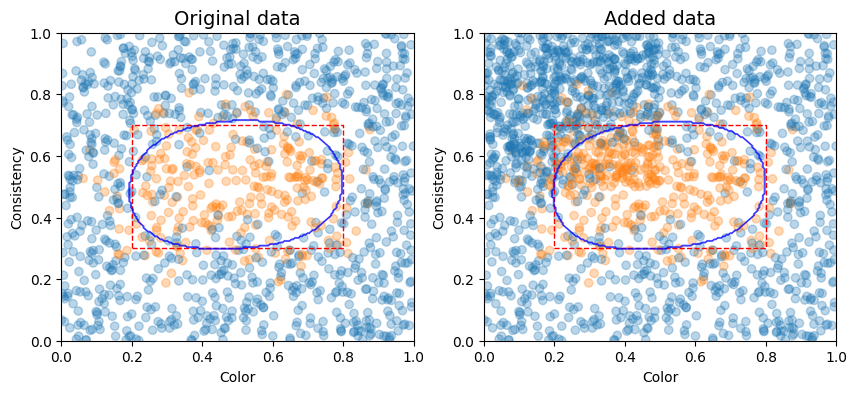

In [17]:
# Put data into a DataFrame:
orig_df  = pd.DataFrame({'color':color, 'consist':consist, 'tasty':tasty})
# Fit model to original data:
orig_svc = SVC()
orig_svc.fit(np.transpose([orig_df['color'], orig_df['consist']]), orig_df['tasty'])

# Generate new data:
color2   = rng.random(n_samples * 2)
consist2 = rng.random(n_samples * 2)
tasty2   = tastyness(color2, consist2, noise) # We did not specify a seed for the noise.
data_df  = pd.DataFrame({'color':color2, 'consist':consist2, 'tasty':tasty2})
# Predict based on new data:
k_pred2  = orig_svc.predict(np.transpose([data_df['color'], data_df['consist']]))
 
# Join old and part of the new data:
concat_df = pd.concat([orig_df, data_df.query('color < 0.5 and consist > 0.5')])
#concat_df = pd.concat([orig_df, data_df.query('consist > 0.8')])
#concat_df = pd.concat([orig_df, data_df.loc[k_pred2 == 1]])

# Plot data and decision boundary:
pl.figure(figsize=(10, 4))
for i, df, t in zip(range(2), [orig_df, concat_df], ['Original data', 'Added data']):
    pl.subplot(1,2, i + 1)
    pl.title(t, fontsize=14)
    # Fit model and plot decision boundary:
    svc.fit(np.transpose([df['color'], df['consist']]), df['tasty'])
    aux.plot_predictions(svc)
    # Plot the data:
    aux.mango_scatter_plot(df['color'], df['consist'], df['tasty'])  
    # Plot true boundary:
    ax = pl.gca()
    guess = PatchCollection([patches.Rectangle((0.2, 0.3), 0.6, 0.4)], edgecolor='r', linestyle='--', facecolor='none')
    ax.add_collection(guess)
pl.show()

Answer: more densely sampled regions of the feature space are better predicted, but no biases are introduced.

#### 2.2.3. Basic random split

In [74]:
from sklearn.model_selection import train_test_split

Let's first generate some data:

In [75]:
# Gata generation parameters:
seed       = None
n_samples  = 10
noise      = 0.08
train_frac = 0.5

# Generate the full dataset:
rng = np.random.default_rng(seed)
color   = rng.random(n_samples)
consist = rng.random(n_samples)
tasty   = tastyness(color, consist, noise) # We did not specify a seed for the noise.

# Build DataFrame:
mango_df = pd.DataFrame({'color':color, 'consist':consist, 'tasty':tasty})

# Display:
mango_df

,color,consist,tasty
0,0.293090,0.195092,0
1,0.924194,0.124278,0
2,0.747111,0.746235,0
3,0.767829,0.598314,0
4,0.331243,0.661606,1
5,0.459130,0.343374,1
6,0.185206,0.242907,0
7,0.273222,0.655682,1
8,0.684106,0.358188,1
9,0.103821,0.805298,0


The simplest way to split the data into random disjoint sets is to shuffle the data and then select the first $n_{\mathrm{train}}$ instances as the training set and the remaining instances as the test set. This can be done with the `train_test_split` function, for instance:

In [76]:
# Random split DataFrame:
split_seed = 95033  # You can try `None` as well.
train_df, test_df = train_test_split(mango_df, train_size=train_frac, random_state=split_seed)

**Important:** Always set the random_state (seed) of the pseudo-random number generator. This will prevent the data from separate sets to get mixed up between runs and will allow for reproducibility.

In [77]:
# Display train dataset:
train_df.sort_index()

,color,consist,tasty
0,0.293090,0.195092,0
1,0.924194,0.124278,0
3,0.767829,0.598314,0
4,0.331243,0.661606,1
7,0.273222,0.655682,1


In [78]:
# Display test dataset:
test_df.sort_index()

,color,consist,tasty
2,0.747111,0.746235,0
5,0.459130,0.343374,1
6,0.185206,0.242907,0
8,0.684106,0.358188,1
9,0.103821,0.805298,0


Let's do the same thing, but using Numpy arrays:

In [79]:
# Random split arrays:
train_color, test_color, train_consist, test_consist, train_tasty, test_tasty = train_test_split(color, consist, tasty, train_size=train_frac, random_state=split_seed)

# First entries of the train set:
print('Train set:')
aux.print_arrays_heads([train_color, train_consist, train_tasty], ['color', 'consist', 'tasty'], 6)

# First entries of the test set:
print('Test set:')
aux.print_arrays_heads([train_color, train_consist, train_tasty], ['color', 'consist', 'tasty'], 6)

Train set:
color:   [0.27322222 0.33124348 0.29309001 0.9241942  0.7678288 ]
consist: [0.655682   0.66160575 0.19509216 0.12427847 0.59831418]
tasty:   [1 1 0 0 0]
Test set:
color:   [0.27322222 0.33124348 0.29309001 0.9241942  0.7678288 ]
consist: [0.655682   0.66160575 0.19509216 0.12427847 0.59831418]
tasty:   [1 1 0 0 0]


**Important:** this procedure works if your dataset does not get updated between multiple fits. If it does, the data that was in one set (e.g. validation set) 
might get into another (e.g. test set) after more data is added. This would break the "unseeness" of the validation and test data. Let's see an example:

In [80]:
# Add new data:
extra_data_df = pd.DataFrame({'color': [0.666666, 0.999999], 'consist':[0.666666, 0.999999], 'tasty':[1, 0]}, index=[n_samples, n_samples + 1])
added_data_df = pd.concat([mango_df, extra_data_df])
added_data_df

,color,consist,tasty
0,0.293090,0.195092,0
1,0.924194,0.124278,0
2,0.747111,0.746235,0
3,0.767829,0.598314,0
4,0.331243,0.661606,1
5,0.459130,0.343374,1
6,0.185206,0.242907,0
7,0.273222,0.655682,1
8,0.684106,0.358188,1
9,0.103821,0.805298,0


In [81]:
# Split the data with the same seed:
new_train_df, new_test_df = train_test_split(added_data_df, train_size=train_frac, random_state=split_seed)

Compare the entries in the new test set with the previous one. Instances that were in the training set are now in the test set:

In [83]:
# Original test set:
test_df.sort_index()

,color,consist,tasty
2,0.747111,0.746235,0
5,0.459130,0.343374,1
6,0.185206,0.242907,0
8,0.684106,0.358188,1
9,0.103821,0.805298,0


In [82]:
# New test set after adding data:
new_test_df.sort_index()

,color,consist,tasty
2,0.747111,0.746235,0
4,0.331243,0.661606,1
6,0.185206,0.242907,0
7,0.273222,0.655682,1
8,0.684106,0.358188,1
11,0.999999,0.999999,0


#### 2.2.2. Splitting with a hash function

One way to solve the problem above is to use a [hash function](https://en.wikipedia.org/wiki/Hash_function). We adapted the implementation by [Aurélien Geron](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) to strings:

In [84]:
from zlib import crc32

def hash_string(string, prefix=''):
    """
    Takes a `string` as input, remove `prefix` from it and turns it into a hash.
    """
    name   = string.replace(prefix, '')
    return crc32(bytes(name, 'utf-8'))

def test_set_check_by_string(string, test_frac, prefix=''):
    """
    Returns a boolean array saying if the data identified by `string` belongs to the test set or not.
    
    Parameters
    ----------
    string : str
        The string that uniquely identifies an example.
    test_frac : float
        The fraction of the complete dataset that should go to the test set (0 to 1).
    prefix : str (default '')
        A substring to remove from `string` before deciding where to place the example.
        
    Returns
    -------
    is_test : bool
        A bool number saying if the example belongs to the test set.
    """

    return hash_string(string, prefix) & 0xffffffff < test_frac * 2**32

def train_test_split_by_string(df, test_frac, col, prefix=''):
    """
    Split a DataFrame `df` into train and test sets based on string hashing.
    
    Input
    -----
    
    df : Pandas DataFrame
        The data to split.
        
    test_frac : float
        The fraction of `df` that should go to the test set (0 to 1).

    col : str or int
        The name of the `df` column to use as identifier (to be hashed).
        
    prefix : str (default '')
        A substring to remove from the rows in column `col` of `df` 
        before deciding where to place the example.
        
    Returns
    -------
    
    The train and the test sets (Pandas DataFrames).
    """
    ids = df[col]
    in_test_set = ids.apply(lambda s: test_set_check_by_string(s, test_frac, prefix))
    return df.loc[~in_test_set], df.loc[in_test_set]

Let's see how the hash function works:

In [85]:
# Exploring the hash function:
print(hash_string('my id'))
print(hash_string('my ic'))
print(hash_string('0'))
print(hash_string('1'))

1998231736
3917352219
4108050209
2212294583


Applying it to our toy data:

In [86]:
# Add an ID string to dataset:
prefix = 'i'
mango_df['id'] = prefix + mango_df.index.astype(str)
added_data_df['id'] = prefix + added_data_df.index.astype(str)

# Split the original and expanded datasets:
train_df,     test_df     = train_test_split_by_string(mango_df, 1 - train_frac, 'id')
new_train_df, new_test_df = train_test_split_by_string(added_data_df, 1 - train_frac, 'id')

In [87]:
# Original test set:
test_df

,color,consist,tasty,id
2,0.747111,0.746235,0,i2
3,0.767829,0.598314,0,i3
6,0.185206,0.242907,0,i6
7,0.273222,0.655682,1,i7


In [88]:
# Test set after adding new data:
new_test_df

,color,consist,tasty,id
2,0.747111,0.746235,0,i2
3,0.767829,0.598314,0,i3
6,0.185206,0.242907,0,i6
7,0.273222,0.655682,1,i7
10,0.666666,0.666666,1,i10
11,0.999999,0.999999,0,i11


### 2.3. The goal is to minimize a cost function

In [ ]:
from IPython.display import Image
import tensorflow as tf

In any ML model, we define a function called "cost function" that specifies the quality of the model's predictions (better saying, the level of error). 
Thus, our goal is to **minimize this cost function**. The properties of the cost function and the method used to minimized it varies and depends on the 
class of models chosen. Below we se a possible example of a generic cost function.

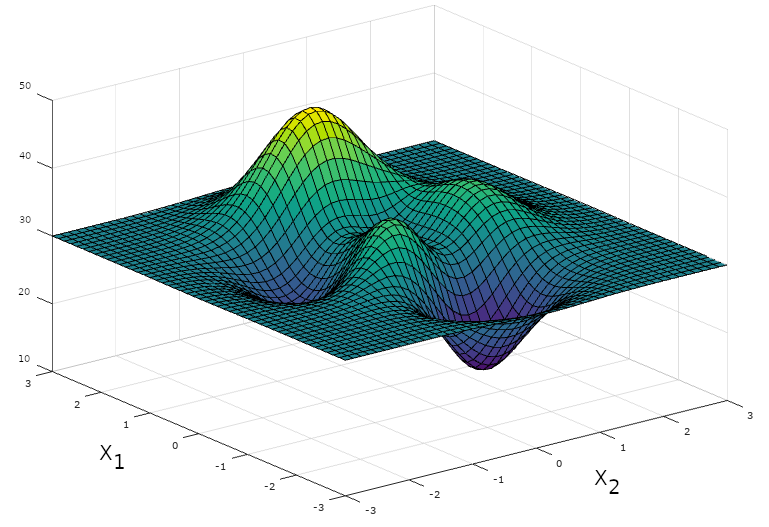

In [4]:
Image('imagens/05_2d-surface.png')

We see that the cost function may have local minima, and some methods (like _gradient descent_) might get stuck in it and not reach the global minimum. Some models (like linear models) have convex cost functions (only one minimum) and aanlytical or numerical methods to find it. 

For regression problems, it is common to use the mean squared error as the cost function. And for neural networks, the cost function is minimized using the Stochastic Gradient Descent (SGD) method. Let's see this method in action. First, we set up the problem (generate data and instantiate a model):

In [7]:
# Set parameters of the example:
ex_n     = 100
ex_seed  = 6547
ex_xmin  = -1.5
ex_xmax  =  1.5
ex_noise = 0.3

# Generate 3rd-degree polynomial data:
ex_rng   = np.random.default_rng(ex_seed)
ex_x     = ex_rng.uniform(low=ex_xmin, high=ex_xmax, size=ex_n)
ex_y     = 2 * ex_x * (ex_x - 1) * (ex_x + 1) + 2 + ex_rng.normal(scale=0.5, size=ex_n)

# Define model degree and prepare data (compute powers of x):
sgd_degree   = 3
preprocessor = Pipeline([('poly', PolynomialFeatures(sgd_degree, include_bias=False)), ('scal', StandardScaler())])
ex_X   = preprocessor.fit_transform(np.transpose([ex_x]))

# Data points for plotting model's predictions:
x_plot = np.arange(ex_xmin, ex_xmax, 0.1)
X_plot = preprocessor.transform(np.transpose([x_plot]))

# Create linear model that uses the Stochastic Gradient Descent minimization method:
learning_rate = 0.1
sgd_model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(sgd_degree,))])
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True)
#opt = tf.keras.optimizers.RMSprop()
sgd_model.compile(optimizer=opt, loss='mean_squared_error')

rme_list = []

2023-03-31 16:36:58.742819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:36:58.767975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:36:58.768147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:36:58.768950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Next, we gradually improve the model's fit using the SGD method. Each time the code below is ran, the model improve its performance (i.e. reduces its mean squared error):

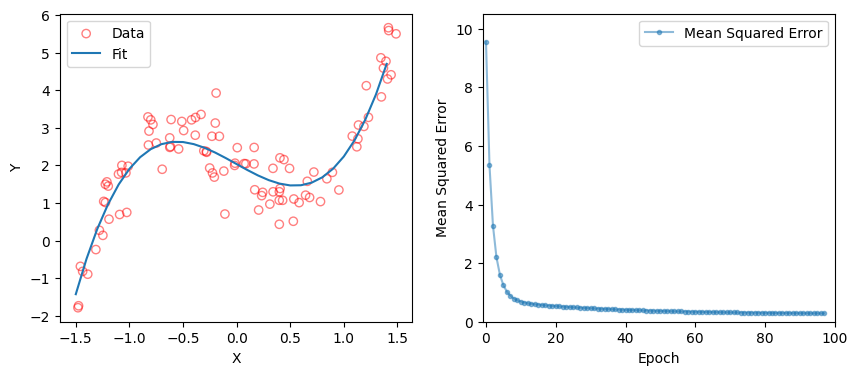

In [27]:
# Take a step in Gradient Descent and plot the fit:

n_epochs = 1
history  = sgd_model.fit(ex_X, ex_y, epochs=n_epochs, batch_size=ex_n, verbose=None)
y_plot = sgd_model.predict(X_plot, verbose=None)[:,0]

rme_list = rme_list + history.history['loss']
pl.figure(figsize=(10, 4))

pl.subplot(1,2,1)
pl.scatter(ex_x, ex_y, edgecolor='r', facecolor='none', alpha=0.5, label='Data')
pl.plot(x_plot, y_plot, label='Fit')
pl.xlabel('X')
pl.ylabel('Y')
pl.legend()

pl.subplot(1,2,2)
pl.plot(rme_list, marker='.', alpha=0.5, label='Mean Squared Error')
pl.xlim([-1, 100])
pl.ylim([0, max(rme_list) * 1.1])
pl.xlabel('Epoch')
pl.ylabel('Mean Squared Error')
pl.legend()
pl.show()

## 3.  Framing the problem

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 3.1. The big picture

**Our goal:** to create an ML model that takes as input the DOU notices (i.e. its text and, possibly, other relevant data) and outputs a value for each notice associated to its relevance, so the notices can be sorted: the most relevant ones should appear on the top of the list (this is the so-called **pointwise approach**). In this way, a human evaluator could read the notices starting from the most relevant ones, and stop the reading at a point we are confident there are no more relevant notices further down the list.from IPython.display import Image

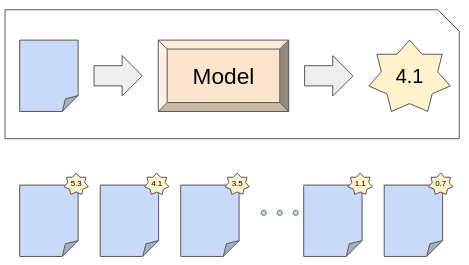

In [3]:
Image(filename='imagens/10_framing-the-problem_goal-small.png') 

* We have to give to the model examples of notices already labeled according to their relevance as perceived by us (the users). So this is a case of **supervised learning**.
* We want the notices to be sorted, and thus their labels should be ordinal. Although we could adopt [different strategies](https://arxiv.org/abs/2010.06467), we will frame the problem as a **regression task**.
* We will adopt the common strategy of labeling the notices on a relevance scale from 1 (least relevant) to 5 (most relevant). The data we already have annotated contains integer labels only, but **I would recommend using a continuous scale**.

### 3.2. Creating features (vectorizing the text)

Machine learning models can only operate with numbers (they are just complicated mathematical functions that takes as input many numbers and outputs another number). In order for it to work with text, we have to create numbers that represent the text's characteristics we believe to be relevant for the task at hand, that is, we have to **create features that describe the text**. The process of transforming a text into a bunch of numbers is called **vectorization**.

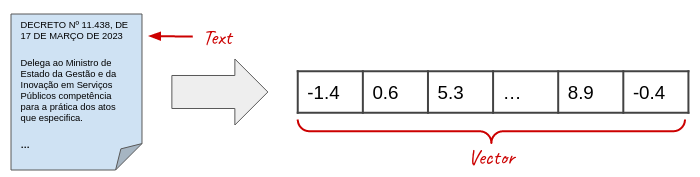

In [4]:
Image(filename='imagens/20_framing-the-problem_text-vectorization.png') 

#### 3.2.1. Manual features

We could create, one by one, features we believe signal the relevance of a notice. For instance, 
if we are trying to detect nominations to important positions, we could look for: keywords related 
to the position level; surnames that could indicate nepotism; and values of compensations and salaries. E.g.:

_"The Minister of Education appoints GABRIEL JÚLIO DA SILVA as Chief of Staff (DAS-4) 
in the Secretary of Higher Education, with a salary of R$ 6.500,00."_

In [40]:
pd.DataFrame({'nepotism_flag':[0], 'is_das':[1], 'das_level':[4], 'salary':[6500.0]})

,nepotism_flag,is_das,das_level,salary
0,0,1,4,6500.0


Unless the information important for ranking the texts is clearly contained in a few features, this strategy is costly and not very effective.

#### 3.2.2. Bag-of-words

This strategy consists of checking if (or how many times) certain words from a _vocabulary_ appear in the text. The _vocabulary_ can be built from all the texts (_corpus_) in the training set. For instance let's take a simple and small _corpus_ as an example of a training set:

In [41]:
# Take an example of training set:
toy_train_set = ['First, this is the first document in the corpus.', 
                 'This is the second document in the corpus.', 
                 'The corpus is the set made of the first text and the second text and all other texts!']

# Create a vocabulary from it:
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(toy_train_set)
# Show the vocabulary:
vocab = vectorizer.get_feature_names_out()
vocab

array(['all', 'and', 'corpus', 'document', 'first', 'in', 'is', 'made',
       'of', 'other', 'second', 'set', 'text', 'texts', 'the', 'this'],
      dtype=object)

Then, we transform the each text into a vector:

In [42]:
# Count the occurences of each word (actually a token) in each document: 
vectors = vectorizer.transform(toy_train_set)
X_train = pd.DataFrame(data=vectors.toarray(), columns=vocab)
# Show the resulting vectors for each document:
X_train

,all,and,corpus,document,first,in,is,made,of,other,second,set,text,texts,the,this
0,0,0,1,1,2,1,1,0,0,0,0,0,0,0,2,1
1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,2,1
2,1,2,1,0,1,0,1,1,1,1,1,1,2,1,4,0


**Remarks**
* We can **preprocess** the text to reduce the number of unnecessary distinctions (e.g. the case of the words) 
and uninformative words (called _stop words_, such as 'the', 'of', 'this'...). There are many options on what to do at this stage.
* Instead of words, we can identify the presence of other kinds of tokens (e.g. letters, syllables, pairs of adjacent words - called _bigrams_ -, and so on).
* We can make the vectorization binary (i.e. only informs whether the token is present or not in the text).
* We can apply normalizations and weights (such as the Inverse Document Frequency - IDF) to the token counts. 
Check the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html}) for all the options.

#### 3.2.3. Word embedding

The _bag-of-words_ approach treat all words as completely different features, so it is not aware of synonyms or classes of words. 
In the example above, there is nothing to inform the model that 'text', 'texts' and 'documents' mean similar things, so their impact on the output should be similar as well.
Moreover, this representation is inefficient: extracting the vocabulary from a large corpus might result in hundres of thousands of features whose values are mostly zero 
(in a bag-of-words vectorization, a word is represented as a vector full of zeros, apart from a single "1" at just one place: the feature corresponding to counts of that word).
This representation is called _sparse_ and makes the data noisy.

An alternative is to use _word embeddings_: each word is represented by a _dense vector_, and in a way that words with similar meanings have similar vectors, so their effect in the final 
output is also similar. In the example above, instead of representing the words as:

    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # 'document'
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]  # 'text'
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  # 'texts'
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # 'first'
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  # 'second'
    
we could have (for a 2D embedding):

In [90]:
embeddings = {
'document': [1, 1.2],
'text':     [1.1, 0.88],
'texts':    [0.9, 0.5],
'first':    [-0.7, 1.4],
'second':   [-0.9, 0.8],
}

The (toy) embeddings above are plot below. We see that words semantically close are also close in the vector space.

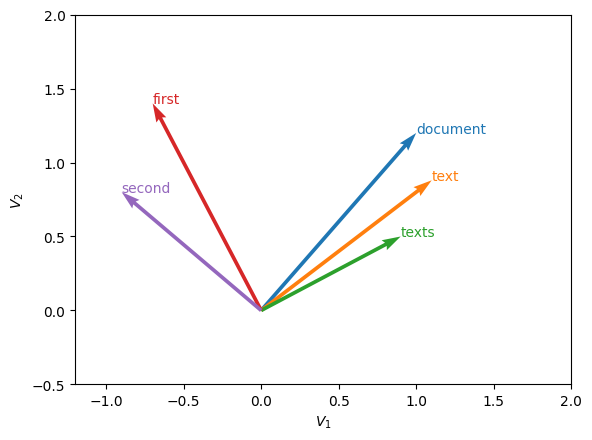

In [91]:
# Plot vectors:
V      = np.array(list(embeddings.values()))
origin = np.zeros((2, len(V))) # origin point
cmap   = pl.get_cmap('tab10')
colors = [cmap(i) for i in range(len(V))]
pl.quiver(*origin, V[:,0], V[:,1], color=colors, angles='xy', scale_units='xy', scale=1)

# Add associated words to vectors: 
names = list(embeddings.keys())
for i, n in enumerate(names):
    pl.text(V[i,0], V[i,1], n, color=cmap(i))

# Format plot:
pl.ylim([-0.5,2]); pl.xlim([-1.2,2])
pl.xlabel('$V_1$'); pl.ylabel('$V_2$')
pl.show()

Word embeddings are used in the context of deep learning by neural network models such as BERT. In this scenario, documents are represented as sequences of word vectors. So the sentence "first text document" would get translated to:

    [[-0.7, 1.4], [1.1, 0.88], [1, 1.2]]

### 3.3. Metrics for ranking

There are many metrics available for checking the performance of a model in text ranking problems. It is a good idea to choose a metric that 
reflects as close as possible the real goal of the model. Assuming that our goal is to find (almost) all the relevant notices -- we don't want 
to miss anything important -- by reading as few notices as possible, I suggest using one of the two possible metrics below.

#### 3.3.1. Recall@$k$

To use the Recall@$k$  metric, first we need to binarize the relevance (set a score threshold above which the notices will be deemed "relevant"). 
Then, Recall@$k$ is simply the fraction of the relevant notices that are selected among the first $k$ notices.

In [92]:
# Toy data (true relevance ordered by score):
sorted_true_relevance = np.array([5, 4, 5, 2, 3, 2, 1, 2, 4, 3, 1])

In [93]:
# Binarize:
threshold = 3.5 
binarized = (sorted_true_relevance > threshold).astype(int)

# Show binarized relevance:
print(binarized)

[1 1 1 0 0 0 0 0 1 0 0]


In [94]:
# Select the first k notices:
k = 5
selected = binarized[:k]
print('Selected:', selected)

Selected: [1 1 1 0 0]


In [95]:
# Compute the recall:
recall = np.sum(selected) / np.sum(binarized)
print('Recall:', recall)

Recall: 0.75


#### 3.3.2. Normalized Discounted Cumulative Gain (nDCG)

We first compute the Discounted Cumulative Gain, DCG, for documents $m$ with true relevance $r_m$ (measured on a scale from 1 to 5) 
that were placed at position $k_m$ by the ranking system.

$$DCG = \sum_m\frac{2^{r_m - 1} - 1}{\log_2(k_m + 1)}$$

By inspecting the formula above, we see that DCG achieves higher values when the most relevant notices (whose numerators are large) appear at the beginning of the ranked list 
(where the denominator is small). As we see in the examples below, this leads to interesting properties:

In [96]:
# Mistaking the order of irrelevant notices have a small effect:
aux.my_ndcg([1,2,3,4,5], [2,1,3,4,5])

0.9979470946084208

In [97]:
# The same flip but for for relevant notices gives a larger penalty:
aux.my_ndcg([1,2,3,4,5], [1,2,3,5,4])

0.8616884617566115

In [98]:
# If a relevant notice is sent further back in the list, the penalty is even larger:
aux.my_ndcg([1,2,3,4,5], [1,2,5,4,3])

0.7189324940540128

In the normalized version of DCG, its value is divided by the one obtained in a perfect ordering:

$$nDCG = \frac{DCG}{DCG_{\mathrm{perfect}}}$$ 

### 3.4. Model and data life cycle

By reading the (filtered) government gazette's notices, people can continue labeling them according to their relevance. This new data can be used 
to retrain and improve the model in a continuous cycle. Here I propose a strategy for this cycle:

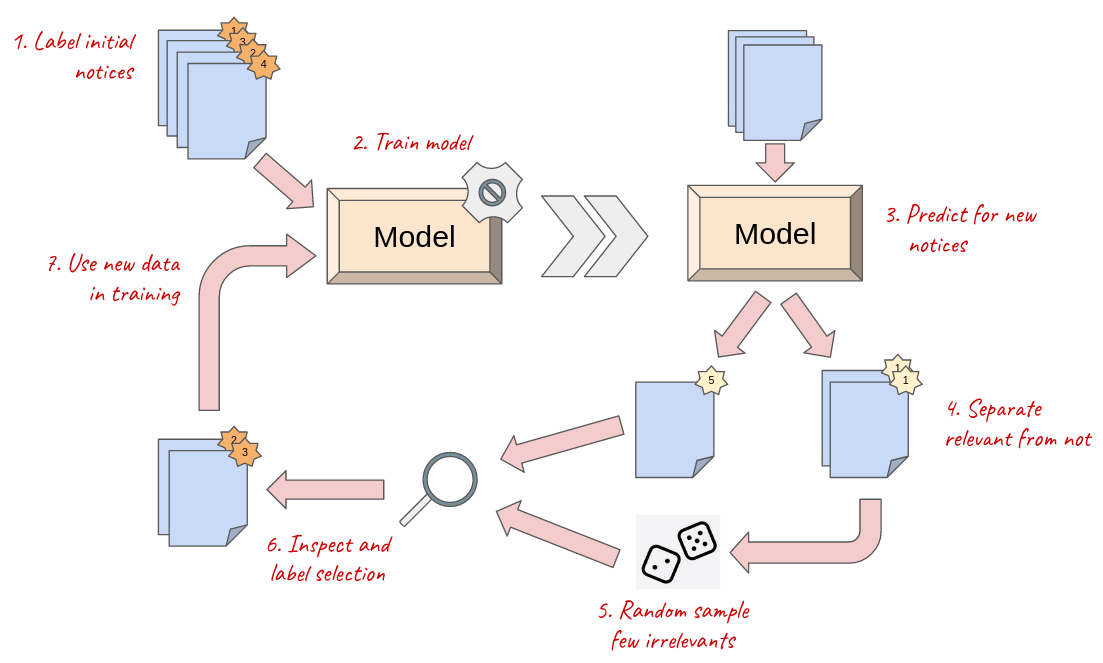

In [5]:
Image(filename='imagens/30_project-life-cycle.png') 

1. Start by reading and labeling notices without any filtering.
2. Once you have read through a few months, train your first model.
3. Use it to predict the relevance of new (daily notices).
4. Apply a threshold on the score (predicted relevance) to separate relevant and irrelevant notices.
3. Keep on labeling the notices you read and saving them on a database;
5. Besides the notices selected as relevant by the model, it is important to add to your reading list a few deemed irrelevant by the model so we can eventually catch false negatives. There are strategies for selecting a diverse and random set of (supposedly) irrelevant notices to improve the chances of catching an error.
6. Do your inspection of daily selected notices and keep on labeling them.
7. Store them in a database and use them to retrain the model.

## 4. Ranking texts with bag-of-words

In [1]:
# Main analysis imports:
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as pl
from importlib import reload

import xavy.data_retriever as xr
import xavy.utils as xu
import xavy.mltools as ml
import xavy.dataframes as xd

import auxiliary as aux

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 4.1. Loading annotated data

We will load DOU notices from section 1 (normative acts) that were annotated in terms of relevance by civil servants working on government oversight between 2020 and 2021. The notices were scraped from the official DOU website: <https://www.in.gov.br/leiturajornal>
* These notices were annotated in a scale from 1 (least relevant) to  5 (most relevant).
* High relevance notices are rare in DOU. As a strategy to increase the number of instances in this category, we will also use notices that were published between 2019 and 2020 on a specialized news service as examples of relevance level 5 notices.
* All the data aboved was concatenated into a single CSV file.
* Some processing was already done to the notices' texts: removing a common standard disclaimer referring to "versão certificada" (certified version).

In [2]:
# Load annotated dataset:
file_name = 'annotated_DOU_notices_n_BRO'
xr.sync_remote_zipped_files('https://nuvem.ceweb.br/s/XzSkEmkp4FjCErP/download/{}.zip'.format(file_name), './data/', keep_zip_dir=False)
annotated_notices_df = pd.read_csv('./data/{}.csv'.format(file_name))

!! Found more than one matching file or folder.
['./data/annotated_DOU_notices_n_BRO.zip', './data/annotated_DOU_notices_n_BRO.csv']
Found a local file, skip download.


Let's see how the data looks like:

In [3]:
# Example of annotated data:
important_cols = ['relevancia', 'identifica', 'edicao', 'data_pub', 'orgao', 'ementa', 'fulltext', 'assina', 'cargo', 'url']
annotated_notices_df[important_cols].sample(5)

,relevancia,identifica,edicao,data_pub,orgao,ementa,fulltext,assina,cargo,url
1763,1,"PORTARIA GSI/PR Nº 71, DE 28 DE SETEMBRO DE 2020",187,2020-09-29,Presidência da República/Gabinete de Segurança...,Estabelece a listagem dos atos normativos vige...,O MINISTRO DE ESTADO CHEFE DO GABINETE DE SE...,AUGUSTO HELENO RIBEIRO PEREIRA,NaN,http://www.in.gov.br/web/dou/-/portaria-gsi/pr...
228,2,"RESOLUÇÃO CNPq Nº 4, DE 27 DE MAIO DE 2021",100,2021-05-28,"Ministério da Ciência, Tecnologia e Inovações/...",NaN,O Presidente do CONSELHO NACIONAL DE DESENVOL...,EVALDO FERREIRA VILELA,NaN,http://www.in.gov.br/web/dou/-/resolucao-cnpq-...
844,3,"RESOLUÇÃO - CONSU Nº 1, DE 2 DE SETEMBRO DE 2021",168,2021-09-03,Ministério da Saúde/Conselho de Saúde Suplementar,Dispõem sobre a Política Nacional de Saúde Sup...,O PRESIDENTE DO CONSELHO DE SAÚDE SUPLEMENTA...,MARCELO ANTÔNIO CARTAXO QUEIROGA LOPES,NaN,http://www.in.gov.br/web/dou/-/resolucao-consu...
3793,1,"RESOLUÇÃO-RE Nº 1.003, DE 2 DE ABRIL DE 2020",66,2020-04-06,Ministério da Saúde/Agência Nacional de Vigilâ...,NaN,"O Gerente de Produtos de Higiene, Cosméticos, ...",ITAMAR DE FALCO JUNIOR,NaN,http://www.in.gov.br/web/dou/-/resolucao-re-n-...
2881,1,"RESOLUÇÃO-RE Nº 1.931, DE 10 DE JUNHO DE 2020",112,2020-06-15,Ministério da Saúde/Agência Nacional de Vigilâ...,NaN,O Gerente-Geral de Tecnologia de Produtos par...,LEANDRO RODRIGUES PEREIRA,NaN,http://www.in.gov.br/web/dou/-/resolucao-re-n-...


For each published DOU notice (row), we have the following information (columns):
1. **relevancia** - the relevance, annotated by the civil servants;
2. **identifica** - the title of the notice;
3. **secao** - the DOU section (in this case, always 1);
4. **edicao** - the DOU edition (a sequential number for each year), which can be followed by a letter in case of an extraordinary edition;
5. **pagina** - the page number (in the PDF version) where the notice was published;
6. **data_pub** - the date of publication;
7. **orgao** - the government organization responsible for the notice (in a standardized, hierarchical structure);
8. **ementa** - the abstract of the notice (sometimes it does not exist);
9. **resumo** - a representative excerpt the scraping system extracted;
10. **fulltext** - the body of the notice (main text, including the signature);
11. **assina** - the servant or authority that signed the notice (there might be more than one person, separated by "|", or none);
12. **cargo** - the position occupied by who signed the notice (it might be empty);
13. **url** - the link to the online (HTML) version of the notice; 
14. **url_certificado** - link to the PDF version of the page containing the notice;
15. **data_registro** - Date and time when the notice was captured by the scraping system.

For ranking the notices, there is valuable information in the fields: identifica, edicao, orgao, ementa, fulltext, assina, and cargo.

### 4.2. Dataset split

Our model is likely to be updated regularly (as new notices get annotated), so we need to guarantee that the instances do not switch datasets when we again split the dataset after adding new data. 
Since each DOU notice is uniquely identified by its URL, we can use the string hash function to split the dataset:

#### **Exercise:** Split the data

Split the dataset `annotated_notices_df` into the sets `train_raw`, `val_raw` and `test_raw` using an appropriate split method and fraction of the data for each set.  

In [4]:
# Write your solution here:


#### **Solution**

In [5]:
# Randomly split dataset using a hash function:
build_raw, test_raw = aux.train_test_split_by_string(annotated_notices_df, 0.15, 'url', 'http://www.in.gov.br/web/dou/-/')
train_raw, val_raw  = aux.train_test_split_by_string(build_raw, 0.17, 'url', 'http://www.in.gov.br/')

#### Continuing...

In [6]:
# Check the amount of each class in each set:
n_ex_by_relevancia = pd.DataFrame()
n_ex_by_relevancia['train'] = train_raw.relevancia.value_counts()
n_ex_by_relevancia['val'] = val_raw.relevancia.value_counts()
n_ex_by_relevancia['test'] = test_raw.relevancia.value_counts()
assert n_ex_by_relevancia.isna().any().any() == False, 'Some set has missing classes'
n_ex_by_relevancia.sort_index()

,train,val,test
1,1760,375,389
2,831,153,169
3,516,96,102
4,426,82,79
5,463,88,102


### 4.3. Preparing the texts

In [13]:
from sklearn.pipeline import Pipeline

# Load custom-made module:
import dou_sorter_common_functions as do

First, we want to select from the raw data the information that is useful for ranking notices; adding useless data to the model input is like adding noise. 
Our intuition, along with insights gained from exploring the data and studying the performance of the model on the validation set, made us create a transformer
(stored in [./dou_sorter_common_functions.py](./dou_sorter_common_functions.py)) that selects and organizes the useful information from the raw data. We instantiate it below:

In [14]:
# Instantiate a preprocessing transformation for DOU data:
textual_cols  = ['tit_org_ementa_text']
dou_extractor = do.PreprocessDOU(['relevancia', 'tipo_edicao'] + textual_cols, 'xxnullxx')

This transformer does 5 things:
* selects only columns that containg useful information, dropping the rest (the signee and her/his position is also present in the 'fulltext' column, so they are not selected);
* from the notice title, 'identifica', it selects only the notice type (decree, law, etc);
* from the organization column, 'orgao', it replaces the '/' for whitespaces;
* these two fields are concatenated into a single text (separated by spaces), along with the abstract ('ementa') and body text ('fulltext'); and
* missing data in any of the concataning fields above are filled with 'xxnullxx'.

Below we show the output of our transformer:

In [15]:
# Take an example of the input data:
examples_df = train_raw.sample(5, random_state=682)

# Check the output of the preprocessor:
extracted_example_df = dou_extractor.transform(examples_df)

# Example of preprocessor output:
display(extracted_example_df)
print(extracted_example_df['tit_org_ementa_text'].iloc[0])

,relevancia,tipo_edicao,tit_org_ementa_text
962,2,Ordinária,portaria Ministério da Economia Secretaria Esp...
4433,2,Ordinária,decreto Atos do Poder Executivo Altera o Decre...
1118,4,Ordinária,decreto Atos do Poder Executivo Dispõe sobre o...
5588,5,Ordinária,resolução Ministério da Infraestrutura Agência...
3108,1,Extra,resolução-re Ministério da Saúde Agência Nacio...


portaria Ministério da Economia Secretaria Especial de Previdência e Trabalho Altera o prazo para comprovação à Secretaria Especial de Previdência e Trabalho do cumprimento de parâmetros gerais relativos aos Regimes Próprios de Previdência Social dos Estados, do Distrito Federal e dos Municípios.   O SECRETÁRIO ESPECIAL DE PREVIDÊNCIA E TRABALHO DO MINISTÉRIO DA ECONOMIA, no uso das atribuições que lhe conferem a alínea "a" do inciso II do art. 71 e o art. 180 do Anexo I ao Decreto nº 9.745, de 08 de abril de 2019, e o inciso VII do art. 1º da Portaria ME nº 117, de 26 de março de 2019, e tendo em vista o disposto no caput e nos §§ 1º a 5º do art. 9º da Emenda Constitucional nº 103, de 12 de novembro de 2019, nos incisos I e III do art. 1º e nos arts. 2º, 3º e 9º da Lei nº 9.717, de 27 de novembro de 1998, nos incisos II, VI e XIV do art. 5º da Portaria MPS nº 204, de 10 de julho de 2018, resolve: Art. 1º Fica prorrogado até 30 de setembro de 2020, exclusivamente para os fins de emissã

Next, we do some standard text preprocessing on the cancatenated textual data. This is done by a second transformer, also stored in [./dou_sorter_common_functions.py](./dou_sorter_common_functions.py).

This second transformer has the following options:
* set the whole text to lower case;
* remove punctuation;
* transform values in R$ into tokens representing logarithmic bins;
* remove a list of words called 'stopwords';
* remove the suffix of the words (stemming);
* remove accents;
* remove numbers and other special characters;
* standardize position codes (e.g. DAS-101.4 and DAS201.4 --> DAS4).

In [16]:
# List of words that do not carry any important information:
stopwords = ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais',
                 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também',
                 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse',
                 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles',
                 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus',
                 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles',
                 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava',
                 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera',
                 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei',
                 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram',
                 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos',
                 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos',
                 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos',
                 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

We used fine-tuning over the validation set to choose the best-performing transformations (these are dependent on other hyperparameters of the model):

In [17]:
# Instantiate a preprocessing transformation for text columns in a DataFrame:
text_preprocessor = do.PreProcessText(lowercase=False, remove_punctuation=True, value_tokens=True, stopwords=stopwords, stemmer=None, 
                                      strip_accents=False, only_letters=False, keep_cash=True, cargo_tokens=True,
                                      text_cols=textual_cols)

# A copy of the original setting in case you decide to change the parameters above:
#text_preprocessor = do.PreProcessText(lowercase=False, remove_punctuation=True, value_tokens=True, stopwords=stopwords, stemmer=None, 
#                                      strip_accents=False, only_letters=False, keep_cash=True, cargo_tokens=True,
#                                      text_cols=textual_cols)

#### **Exercise**: Apply a scikit-learn transformer to the data

Apply the `text_preprocessor` transformer, instantiated above, to the `extracted_example_df` dataset; display its output; and print out the text of a transformed instance. 
You can also change the the parameters of the `text_preprocessor` and check its effects on the data.

In [18]:
# Write your solution here:


#### **Solution**

Below we show the result from applying the text preprocessor to the notices:

In [19]:
# Preprocess the text:
preprocessed_example_df = text_preprocessor.transform(extracted_example_df)

# Example of preprocessor output:
display(preprocessed_example_df)
print(preprocessed_example_df['tit_org_ementa_text'].iloc[0])

,relevancia,tipo_edicao,tit_org_ementa_text
962,2,Ordinária,portaria Ministério Economia Secretaria Especi...
4433,2,Ordinária,decreto Atos Poder Executivo Altera Decreto nº...
1118,4,Ordinária,decreto Atos Poder Executivo Dispõe sobre horá...
5588,5,Ordinária,resolução Ministério Infraestrutura Agência Na...
3108,1,Extra,resoluçãore Ministério Saúde Agência Nacional ...


portaria Ministério Economia Secretaria Especial Previdência Trabalho Altera prazo comprovação Secretaria Especial Previdência Trabalho cumprimento parâmetros gerais relativos Regimes Próprios Previdência Social Estados Distrito Federal Municípios O SECRETÁRIO ESPECIAL DE PREVIDÊNCIA E TRABALHO DO MINISTÉRIO DA ECONOMIA uso atribuições conferem alínea inciso II art 71 art 180 Anexo I Decreto nº 9745 08 abril 2019 inciso VII art 1º Portaria ME nº 117 26 março 2019 tendo vista disposto caput §§ 1º 5º art 9º Emenda Constitucional nº 103 12 novembro 2019 incisos I III art 1º arts 2º 3º 9º Lei nº 9717 27 novembro 1998 incisos II VI XIV art 5º Portaria MPS nº 204 10 julho 2018 resolve Art 1º Fica prorrogado 30 setembro 2020 exclusivamente fins emissão Certificado Regularidade Previdenciária trata inciso IV art 9º Lei nº 9717 27 novembro 1998 prazo comprovação Secretaria Especial Previdência Trabalho medidas tratam alíneas b inciso I art 1º Portaria nº SEPRT 1348 3 dezembro 2019 Art 2º Ficam 

#### Continuing...

We can put these two transformers into a single pipeline:

In [20]:
# Create a proprocessing pipeline:
preprocessor = Pipeline([('dou', dou_extractor), ('pretext', text_preprocessor)])

Here is the result, after applying the pipeline to the raw train and validation data:

In [21]:
# Create a CV set and pre-process it:
train_val_concat = pd.concat([train_raw, val_raw], sort=False)
proc_train_val   = preprocessor.transform(train_val_concat)

We can improve the results by using sample weights: relevant notices are rarer but we care about getting them right, so it makes sense giving them more weight when fitting the data.

In [34]:
# Add sample weight: we care that the most relevant notices are identified:
weight_mapping = {1:1, 2:3, 3:5, 4:10, 5:50}
proc_train_val['weight'] = proc_train_val['relevancia'].map(weight_mapping)

# Separate train and validation samples:
proc_train = proc_train_val[:len(train_raw)]
proc_val   = proc_train_val[len(train_raw):]
# Show examples
proc_train_val.head()

,relevancia,tipo_edicao,tit_org_ementa_text,weight
1,1,Ordinária,portaria seimast Ministério Ciência Tecnologia...,1
2,2,Ordinária,portaria Ministério Infraestrutura Gabinete Mi...,3
3,3,Ordinária,resolução ccfgts Ministério Trabalho Previdênc...,5
4,4,Ordinária,lei Atos Poder Legislativo Altera Lei nº 12212...,10
5,4,Ordinária,decreto Atos Poder Executivo Cria Empresa Bras...,10


### 4.4. Setting the performance zero point

Before trying out a ML model, let's check the performance level a random ranking would lead to. This gives us an idea of the worst case scenario, in which our model cannot predict anything.

#### **Exercise**: Check the metric value for a random sampling

Pass random scores as predictions to nDCG metric `aux.my_ndcg()` to check the zero point performance for the training set `proc_train`. 

In [11]:
# Write your solution here:


#### **Solution**

In [69]:
# Check the performance that would be expected from a random ranking:
rel_rng = np.random.default_rng()
aux.my_ndcg(proc_train['relevancia'], rel_rng.uniform(size=len(proc_train)))

0.7992585326521361

### 4.5. Building and fine-tuning the model 

In [23]:
# For building the model:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

# For fine-tuning:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

# For evaluating:
import dou_model_eval as ev

After preprocessing text, we have to vectorize the text and transform the edition type column in a numerical information. This is done by the transformer `processor` below.

In [24]:
# Build text pipeline:
cropper       = do.CropText(200)
vectorizer    = TfidfVectorizer(lowercase=False, binary=True, ngram_range=(1,2), max_df=1.0, min_df=1, norm=None, use_idf=False)
text_trafo    = Pipeline([('crop', cropper), ('vec', vectorizer)])

# Build encoder for edition type:
encoder_extra = OneHotEncoder(drop='first')

# Build processing pipeline:
processor     = ColumnTransformer([('txt', text_trafo, textual_cols[0]), ('extra', encoder_extra, ['tipo_edicao'])])

Let's see the effect of it on a small piece of data: 

In [25]:
# Get the vocabulary and check how many distinct types of editions there are:
dump = processor.fit(proc_train)
# Vectorize the text and encode the edition type:
X_example = processor.transform(proc_train_val.head())

# Show the results for 5 instances:
feature_names = processor.get_feature_names_out()
X_example_df = pd.DataFrame(data=X_example.toarray(), columns=feature_names)
X_example_df.sort_values(0, axis=1, ascending=False)

,extra__tipo_edicao_Ordinária,txt__ata reunião,txt__vigor data,txt__PDTI,txt__revoga Portaria,txt__ata,txt__Aprovar Plano,txt__maio 2021,txt__revoga,txt__comissão aprovada,...,txt__IV programas,txt__IV promover,txt__IV promoção,txt__IV propiciar,txt__IV propor,txt__IV proporcionar,txt__IV proposição,txt__IV proteção,txt__IV psicólogos,txt__VP
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that each instance is turned into a very long vector. One column tells whether the edition is ordinary of not, and the rest tell wether a given word appears in the text.

The next and last part of the model is to add a regressor to it. We will use a linear regression, whose relevance prediction $\hat{y}^{(m)}$ for the notice $m$ is given by:

$$\hat{y}^{(m)} = \beta_0 + \sum_{i = 1}^{N}\beta_i\cdot x_i^{(m)}.$$

In the equation above, $x_i^{(m)}$ is the value of the $i$th feature of the model for the instance $m$. In our case (and except for the edition type), 
$x_i^{(m)} \in \{0,1\}$ tells if the respective token was found in the text. The terms $\beta_i$ are the coefficients for the features and $\beta_0$ is called the bias.

To fit the model to a training set with $M$ instances, we will use a **cost function** $L$ that includes a **regularization** term that penalizes the use of too many features:

$$L = \sum_{m=1}^M (y_i - \hat{y}_i)^2 + \alpha \sum_{i=1}^N \beta_i^2.$$

This is called a **Ridge regression** and $\alpha$ is a hyperparameter that controls how much regularization is applied, that is, how much constrained the model is.

#### **Exercise**: Instantiate a Regressor and build a pipeline

Instantiate a `Ridge()` regressor and set its regularization parameter to 300. Create a pipeline called `model` that first apply the `processor` 
transformer do the data (already instantiated above) and then the regressor you just instantiated. In the pipeline, name the first step 'proc' and the second, 'fit'.

In [26]:
# Write your solution here:


#### **Solution**

In [27]:
# Add a regressor to the end of the pipeline:
regressor     = Ridge(alpha=300)
model         = Pipeline([('proc', processor), ('fit', regressor)])

#### Continuing...

Now we will perform the **fine tuning using grid search (or randomized search)**. First, let's plan our search by selecting the hyperparameters we want to test 
and the search method (grid or randomized). Grid search is helpful for understanding how the bias and variance of the model are affected by the hyperparameters, 
and it may be helful for a small search. For a large number of parameter combinations, random search is recommended. 

In [28]:
# Instantiating scorer:
ndcg_scorer = make_scorer(aux.my_ndcg, greater_is_better=True)

In [131]:
# Define the hyperparameters to be tested:
param_grid = {'fit__alpha': [1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5],
              #'proc__txt__crop__max_length': [100, 150, 200, 250, 300, 350, 400],
              'proc__txt__crop__max_length': [50, 100, 200, 500, 1000, 2000]
              #'fit__alpha': [1e2, 3e2, 1e3, 3e3],
              #'proc__txt__vec__use_idf': [False, True],
              #'proc__txt__vec__min_df': [1,3,10, 30, 100, 300],
              #'proc__txt__vec__lowercase': [False, True],
              #'proc__txt__vec__binary': [False, True],
              #'proc__txt__vec__norm': [None, 'l1', 'l2'],
              #'proc__txt__vec__ngram_range': [(1,1), (1,2)]
             }

# Do a Grid or Randomized search with fixed validation set:
test_fold = np.zeros(len(train_val_concat)).astype(int)
test_fold[:len(train_raw)] = -1
ps = PredefinedSplit(test_fold)
grid = GridSearchCV(model, param_grid, cv=ps, scoring=ndcg_scorer, return_train_score=True, n_jobs=7)
#grid = RandomizedSearchCV(model, param_grid, cv=ps, scoring=ndcg_scorer, return_train_score=True, n_jobs=7, n_iter=100)

We could use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) in the grid search (it would give us a more precise performance estimation) but it would be slower.

Now let's run the search!

In [132]:
# Run the hyper parameter search:
dump = grid.fit(proc_train_val, proc_train_val['relevancia'].values, fit__sample_weight=proc_train_val['weight'])

print('Best score:', grid.best_score_)
print('Params:', grid.best_params_)

Best score: 0.973447454099382
Params: {'fit__alpha': 300.0, 'proc__txt__crop__max_length': 200}


The table below shows the results of the hyper parameter trials:

In [133]:
ml.searchCV_table(grid).head(5)

,mean_fit_time,std_fit_time,param_fit__alpha,param_proc__txt__crop__max_length,mean_test_score,std_test_score,mean_train_score,std_train_score
20,3.762530,0.0,300.0,200,0.973447,0.0,0.999109,0.0
26,2.851636,0.0,1000.0,200,0.973301,0.0,0.997034,0.0
14,3.651394,0.0,100.0,200,0.972904,0.0,0.999741,0.0
27,5.617501,0.0,1000.0,500,0.972067,0.0,0.998325,0.0
8,3.736208,0.0,30.0,200,0.971952,0.0,0.999918,0.0


The plot below helps us see when the model transitions from a regime dominated by bias (when underfitting) to a regime dominated by variance (when overfitting), 
and shows the sweet spot, where unseen data is best predicted: 

/home/hxavier/prog/my-python/xavy/mltools.py:2009: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/hxavier/prog/my-python/xavy/mltools.py:2009: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


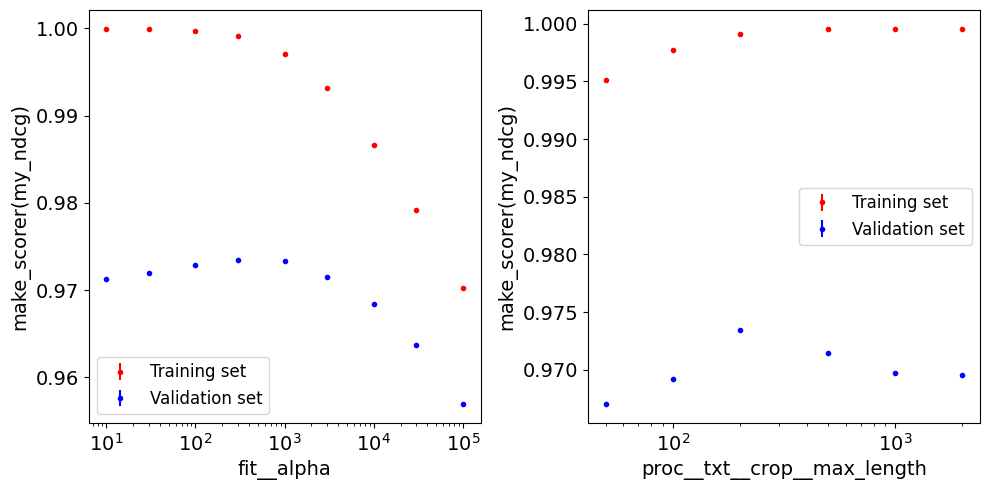

In [134]:
ml.plot_pars_scores(grid, logscale='force')

### 4.6. Evaluating the model

We will use the hyperparameters of the best fit to create a model and fit it to the training data. In this tutorial, the hyperparameters set when first creating the model were already chosen in this fashion. 
Therefore, we just fit it again to the training data and check that the performance is the same as before:

#### **Exercise**: Fit the model and test it

Fit the `model` to our preprocessed training set `proc_train` using the model's `fit()` method; 
don't forget to pass the sample weights through the keyword argument `fit__sample_weight`.
Make predictions for the validation set `proc_val` 
and store it in a variable called `pred_val`. Use my implementation of the metric nDCG, `aux.my_ndcg()`, to check the performance of the model on the validation set.

In [29]:
# Write your solution here:


#### **Solution**

In [30]:
# Fit the best model to the training data:
dump = model.fit(proc_train, proc_train['relevancia'], fit__sample_weight=proc_train['weight'])
# Predict on the validation data:
pred_val = model.predict(proc_val)
# Check the metric is correct (PS: nDCG formula requires lowest relevance to be 0):
aux.my_ndcg(proc_val['relevancia'].values, pred_val)

0.9734121743302885

#### Continuing...

The metric above is hard to interpret. Below we see how the predicted relevance in distributed for notices with different true relevance.

The box extends from the Q1 to Q3 quartile values of the data,
with a line at the median (Q2). The whiskers extend from the edges
of box to show the range of the data. By default, they extend no more than
`1.5 * IQR (IQR = Q3 - Q1)` from the edges of the box, ending at the farthest
data point within that interval. Outliers are plotted as separate dots.

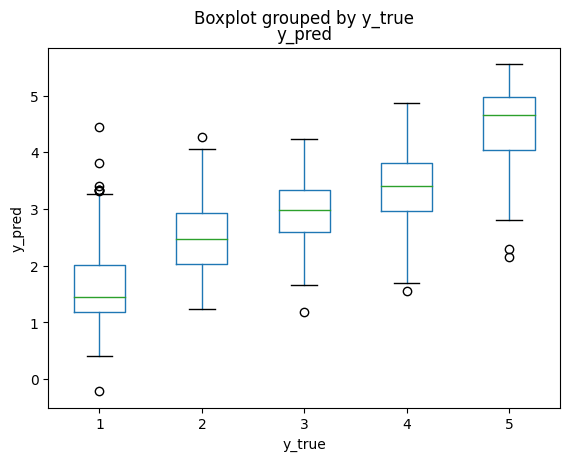

In [136]:
# Box plot of the distribution of predicted relevances per true relevance:
y_pred_true_df = pd.DataFrame({'y_pred':pred_val, 'y_true': proc_val['relevancia'].values}, index=proc_val.index)
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
pl.ylabel('y_pred')
pl.show()

Another way of interpret the results is to plot the fraction of notices with true relevance 4 or 5 that gets selected (recall) as we include in our selection,
in the order they were ranked, more and more notices (this is called Recall@$k$, where $k$ is the number of notices selected). 
The plot below compares such metric with the ones obtained when the notices are randomly ordered and when 
they are perfectly ordered.

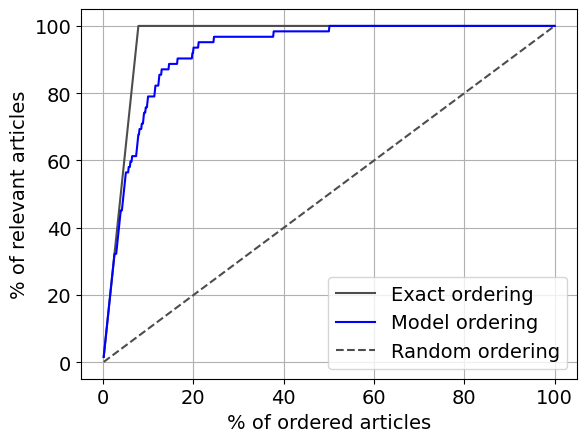

In [137]:
# Hard-coded distribution of relevances "in the wild" (as seen daily on DOU):
original_relevance_dist = pd.Series([988,160,112,69,68], index=[1,2,3,4,5], name='orig_counts')
original_relevance_dist = original_relevance_dist / original_relevance_dist.sum()

# Compute weights for sampling validation data as data in the wild:
wild_dist_weights = original_relevance_dist / proc_val['relevancia'].value_counts(normalize=True)
wild_dist_weights.name = 'wild_weights'
# Assign weights to instances:
wild_weights = proc_val.join(wild_dist_weights, on='relevancia')['wild_weights']

# Sample data as seen in the wild:
wild_val_df = proc_val.sample(len(proc_val), replace=True, weights=wild_weights, random_state=2891)
# Predict reelvance:
pred_wild_val = model.predict(wild_val_df)
# Plot:
ev.plot_fancy_recall_curve(wild_val_df['relevancia'].values, pred_wild_val, 'b')

To have an idea if gathering more data would be beneficial to the performance, let's check the **learning curve**. 
To compute the learning curve, we undersample the training data to various fractions, fit the model to it and evaluate on the validation set. If the model's performance on the validation set was increasing as we approach the full training set, then it is likely that adding more data will improve your model.

In [106]:
from sklearn.model_selection import learning_curve

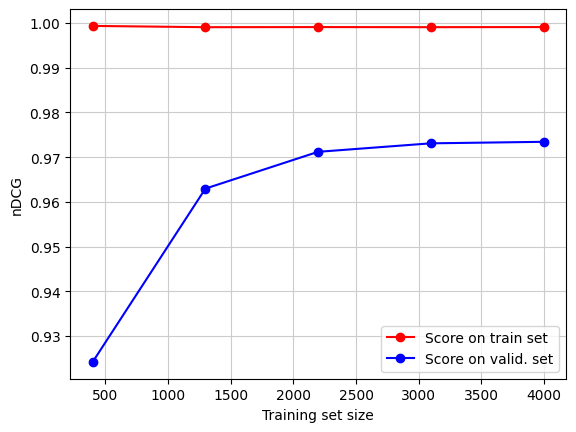

In [139]:
# Compute the learning curve:
train_size, train_score, test_score = learning_curve(model, proc_train_val, proc_train_val['relevancia'].values, cv=ps, scoring=ndcg_scorer, n_jobs=5, shuffle=True, 
                                                     fit_params={'fit__sample_weight': proc_train_val['weight']})

# Plot the learning curve:
pl.plot(train_size, train_score[:,0], color='r', marker='o', label='Score on train set')
pl.plot(train_size, test_score[:,0], color='b', marker='o', label='Score on valid. set')
pl.xlabel('Training set size')
pl.ylabel('nDCG')
pl.grid(color='0.8')
pl.legend()
pl.show()

### 4.7. Important positions in text 

In [26]:
from scipy.signal import savgol_filter
from sklearn.base import clone

In this section we are interested in finding out where, tipically, the important terms for determining the relevance of a DOU notice lie. 
Are they at the beggining of the notice? Are they at the end? Are they scattered all around or are they concentrated at certain locations?
Answering this question might help us in two ways: first, feeding uninformative data to the model is the same as feeding noise and will cause more harm than good;
second, more complex models like BERT (that will be explored in the next section) have a limit on the number of words (actually, tokens) it accepts as input.

To tackle this question we will use the coefficients obtained from the bag-of-words model fitted over the whole texts. Each token present in the notice contributes with its 
coefficient value to the notice's final score. First, let's find out the contribution of each token:

In [27]:
# Fit the model using the whole text:
end_model = clone(model).set_params(proc__txt__crop__max_length=None)
dump = end_model.fit(proc_train, proc_train['relevancia'], fit__sample_weight=proc_train['weight'])

# Get feature names:
features = end_model[:-1].get_feature_names_out()
# Get feature coefficients:
coefs = end_model['fit'].coef_

# Build Dataframe:
features_df = pd.DataFrame({'feature': features, 'coef': coefs})
features_df['is_text'] = features_df['feature'].str.contains('txt__').astype(int)
features_df['token']   = features_df['feature'].str.extract('txt__(.*)')[0]
features_df['ngram']   = features_df['token'].str.split(' ').str.len().fillna(0).astype(int)

The sample below are examples of tokens that indicate lower relevance than the average (according to the annotators). Some insights we extract from them are:
* Certain types of notices (Portarias, Regimentos) are less relevant than others.
* The absence of an abstract is a sign of a less important notice.
* Positions at the bottom of the government hierarchy points to lower relevance.
* Common names such as "José" and "Silva" are associated to low relevance notices. This likely reflects inequalitiy and racism 
  in Brazil, where people that get prestigious positions are usually european descendants from middle/upper classes;
* Typos and other artifacts might carry information about the relevance of the notice (however, it is not clear if this feature is representative of future notices).
* When specific companies are mentioned, it is likely that the notice deals with minor regulatory and bureaucratic issues, and thus are not as relevant 

In [28]:
features_df.query('coef < -0.02').sample(10)

,feature,coef,is_text,token,ngram
408477,txt__Economia Gabinete,-0.021189,1,Economia Gabinete,2
350482,txt__Colegiada Dispõe,-0.023072,1,Colegiada Dispõe,2
1117121,txt__investimentos,-0.020722,1,investimentos,1
1343564,txt__remanescentes,-0.021532,1,remanescentes,1
923638,txt__desta Resolução,-0.029930,1,desta Resolução,2
1388015,txt__setembro 2020,-0.038011,1,setembro 2020,2
1282093,txt__produto,-0.022940,1,produto,1
48115,txt__12 março,-0.021618,1,12 março,2
533437,txt__Ministério,-0.062802,1,Ministério,1
146182,txt__26 fevereiro,-0.022094,1,26 fevereiro,2


Now we inspect tokens with high positive coefficients. We note that:
* The model might focus on specific signee's names (e.g. Bolsonaro) that might not be representative of future notices.
* It draws information from laws and other notices mentioned by the notice itself.
* The existance of articles in the notice indicates it is a normative (and more relevant) document.

In [29]:
features_df.query('coef > 0.02').sample(10)

,feature,coef,is_text,token,ngram
370825,txt__DE 2020O,0.023273,1,DE 2020O,2
189125,txt__407 setembro,0.024790,1,407 setembro,2
302622,txt__BOLSONARO Jorge,0.027562,1,BOLSONARO Jorge,2
505125,txt__LUIZ DE,0.025746,1,LUIZ DE,2
624028,txt__Resolução 03,0.040593,1,Resolução 03,2
281837,txt__Amazônia Legal,0.024212,1,Amazônia Legal,2
1387717,txt__sessão realizada,0.026834,1,sessão realizada,2
256171,txt__9º incisos,0.028994,1,9º incisos,2
1501905,txt__único,0.022197,1,único,1
1108118,txt__inteiros vinte,0.025954,1,inteiros vinte,2


Now let's estimate the average weight we find at each position (measured in words) in a notice. First we create translators from token to 
coefficients and create functions that transforms the documents into an ordered list of words. By combining both, we can compute, for each 
document, the coefficients coming from each position.

In [30]:
# Build mapping from token to coef:
unigram_coefs = features_df.query('ngram == 1').set_index('token')['coef'].to_dict()
bigram_coefs  = features_df.query('ngram == 2').set_index('token')['coef'].to_dict()

# Get tokenizer:
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

def position_coefs(doc, preprocessor, tokenizer, unigram_coefs, bigram_coefs):
    """
    Get the coefficient associated to each position in the document
    (the position being the word count -- in case of bigrams, the 
    position of the last word).
    """
    # Get ngrams in the order they appear:
    unigrams = aux.doc_to_word_list(doc, preprocessor, tokenizer)
    bigrams = ['{} {}'.format(t1, t2) for t1, t2 in zip(unigrams[:-1], unigrams[1:])]
    
    # Get their coefficients (bigram position at its end):
    pos1_coefs = np.array([unigram_coefs[t] for t in unigrams])
    pos2_coefs = np.array([0] + [bigram_coefs[t] for t in bigrams])

    # Sum contributions from both types of ngrams:
    pos_coefs = pos1_coefs + pos2_coefs
    
    return pos_coefs

Now we apply these functions to the notices and compute the average for the positive and negative contributions at each position:

In [31]:
# Get coefficients at all positions for all notices:
max_doc_len  = proc_train['tit_org_ementa_text'].apply(lambda x: aux.doc_to_word_list(x, preprocessor, tokenizer)).str.len().max()
corpus_coefs = np.array([aux.pad_array(position_coefs(doc, preprocessor, tokenizer, unigram_coefs, bigram_coefs), max_doc_len) for doc in proc_train.query('relevancia < 9.5')['tit_org_ementa_text']])

# Compute the average coefficient for each position:
pos_weight_raw =  corpus_coefs.clip(min=0).mean(axis=0)
neg_weight_raw = -corpus_coefs.clip(max=0).mean(axis=0)
all_weight_raw =  corpus_coefs.mean(axis=0)

# Smooth the curves:
window = 10
poly_order = 3
pos_weight = savgol_filter(pos_weight_raw, window, poly_order)
neg_weight = savgol_filter(neg_weight_raw, window, poly_order)
all_weight = savgol_filter(all_weight_raw, window, poly_order)

The plot below shows the (absolute) average positive and negative coefficients as a function of text position. We see that both are concentrated at the beginning of the notices. 
Three factors may contribute to this:
1. Notices end at certain position, after which the coefficient is considered to be zero.
2. Usually, one can find out if the notice is relevant or not from its type (stated in the title), the abstract and the first few articles.
3. This might reflect the lazyness (or wisdom) of the annotators that give up reading boring long notices after a few paragraphs. 

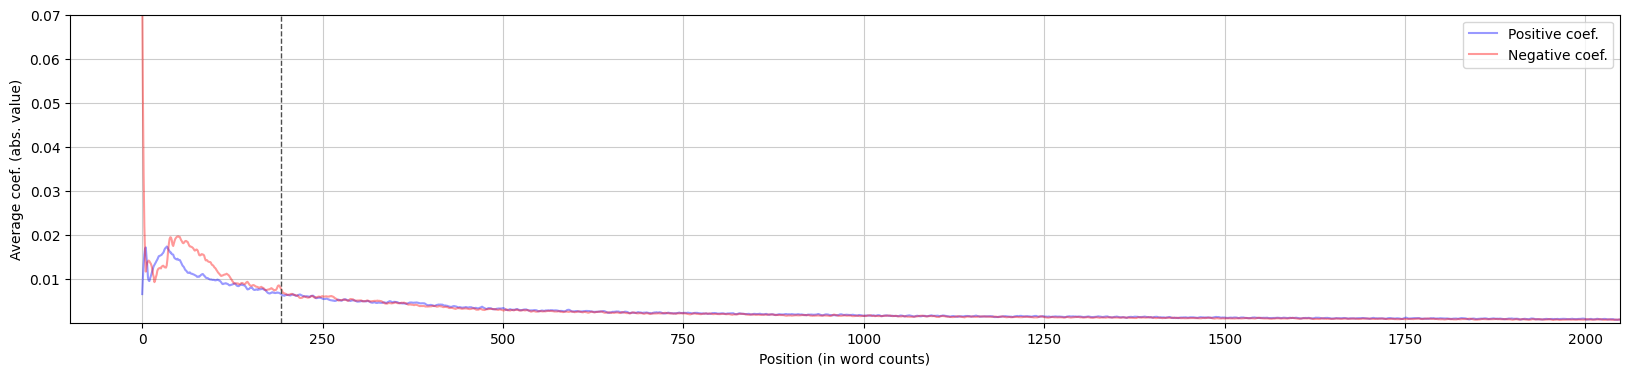

In [32]:
# Plot the average coefficient per position in the text:
pl.figure(figsize=(20,4))
pl.plot(pos_weight, alpha=0.4, color='b', label='Positive coef.')
pl.plot(neg_weight, alpha=0.4, color='r', label='Negative coef.')
#pl.yscale('log')
pl.ylim([1e-4, 7e-2])
pl.xlim([-100, 512 * 4])
pl.legend()
pl.xlabel('Position (in word counts)')
pl.ylabel('Average coef. (abs. value)')
pl.grid(color='0.8')
pl.axvline(384 / 2, color='0.3', linestyle='--', linewidth=1)
pl.show()

## 5. Ranking texts with deep learning

In [58]:
# Install Hugging Face transformers package:
transformers_spec = find_spec('transformers')
if transformers_spec is None:
    !pip install transformers

# Install Hugging Face datasets package:
datasets_spec = find_spec('datasets')
if datasets_spec is None:
    !pip install datasets

In [6]:
import tensorflow as tf
# Hugging Face:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import Dataset
from transformers import DefaultDataCollator

import dou_sorter_common_functions as do
import neural_aux as ne

2023-04-01 19:27:31.705549: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/hxavier/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will now use deep learning (i.e. neural networks with many layers), specifically the BERT model, to predict the relevance of DOU notices. Apart from its 
flexibility (BERT base has around 110M parameters), BERT is pretrained with HUGE unsupervised datasets on tasks like guessing masked words or predicting if two sentences 
follow one another. In this process, BERT builds an internal representation of the language that might come in handy for downstream tasks. This is called **transfer learning**.  

We start my loading from Hugging Face a BERT model pretrained on the language we want to work with. Here are some choices:
* [BERT](https://github.com/google-research/bert) (english)
* [BERTimbau](https://github.com/neuralmind-ai/portuguese-bert) (portuguese)
* [BETO](https://github.com/dccuchile/beto) (spanish)
* [multilingual BERT](https://huggingface.co/bert-base-multilingual-cased) (ensemble)

In [7]:
# Specify the model to load from Hugging Face:
model_name = 'neuralmind/bert-base-portuguese-cased'
# Load model and its tokenizer:
bert_tokenizer  = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
bert_model      = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

2023-04-01 19:27:35.784627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 19:27:35.809543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 19:27:35.809727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 19:27:35.810867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### 5.1. Prepare dataset

As in the bag-of-words model, we start by preprocessing the text. The function below removes the specifics from the title and joins the text fields.
Then, it turns all-caps text into title case (the tokenizer does not recognize all-caps words) and crop ellipsis to only 3 periods (no need for more).

In [8]:
def prepare_text_for_BERT(text_df):
    """
    Prepare a DOU notices DataFrame for usage in a BERT model.
    """
    
    # Hard-coded: regex for identifying start of relevant information:
    preamble_regex = 'resolve[um]?(?:, ad referendum)? ?:|D ?E ?C ?R ?E ?T ?A|(?:DETERMINA|determina)[R:]|determino a sua publicação'
    
    # Create a text column with all textual information about the notices:
    output_df = pd.DataFrame()
    # Join notice type to organization, abstract and main text (but skipping the basis for the action):
    #output_df['joined_text'] = text_df['identifica'].fillna('').apply(do.get_article_type) + '\n' + text_df['orgao'].fillna('') + '\n\n' + text_df['ementa'].fillna('') + '\n\n' + aux.skip_preamble(text_df['fulltext'].fillna(''), preamble_regex)
    output_df['joined_text'] = text_df['identifica'].fillna('').apply(do.get_article_type) + '\n' + text_df['orgao'].fillna('') + '\n\n' + text_df['ementa'].fillna('') + '\n\n' + text_df['fulltext'].fillna('')
    # Replace all caps to title case (saves tokens, as all caps are tokenized letter by letter):
    output_df['joined_text'] = aux.all_caps_to_title(output_df['joined_text'])
    # Limit ellipsis to three periods, to save tokens:
    output_df['joined_text'] = aux.limit_ellipsis(output_df['joined_text'])
    
    # Regression task expects float labels:
    output_df['relevancia'] = text_df['relevancia'].astype(float)
    
    return output_df

In [9]:
# Prepare data for BERT model:
bert_train_df = prepare_text_for_BERT(train_raw)
bert_val_df   = prepare_text_for_BERT(val_raw)

Below we show examples of text inputs and how the BERT tokenizer splits the text into tokens. This BERT implementation uses the **WordPiece tokenizer**.

In [10]:
# Example of BERT tokenization:
ex_notice = bert_train_df['joined_text'].sample().iloc[0]
ex_tokens = bert_tokenizer.tokenize(ex_notice)
ex_n_words = len(ex_notice.split())
print('# words: {}   # tokens: {}'.format(ex_n_words, len(ex_tokens)))
print(ex_notice)
print('')
print(ex_tokens)

# words: 347   # tokens: 541
portaria
Ministério da Economia/Secretaria Especial de Desestatização, Desinvestimento e Mercados/Secretaria de Coordenação e Governança do Patrimônio da União/Superintendência em Pernambuco



 O Secretário DE Coordenação E Governança DO Patrimônio DA União, DA Secretaria Especial DE Desestatização, Desinvestimento E Mercados, DO Ministério DA Economia, no uso da atribuição que lhe confere o art. 102 do Anexo I do Decreto 9.745, de 8 de abril de 2019, com fundamento no art. 5º, parágrafo único, do Decreto-Lei nº 2.398, de 21 de dezembro de 1987, e nos elementos que integram o Processo nº.04962.001920/2008-93, resolve: Art. 1º Declarar de interesse do serviço público para fins de regularização fundiária de interesse social, o imóvel da União, caracterizado como nº 297, de natureza Urbana, situado na Rua Bernardo Vieira de Melo, Bairro do Recife, Município do Recife, Estado de Pernambuco, classificado como terreno parte de marinha e acrescido de marinha, cad

Below we show the distribution of notices by the number of tokens. The vertical dashed line show the BERT limit of 512 tokens.

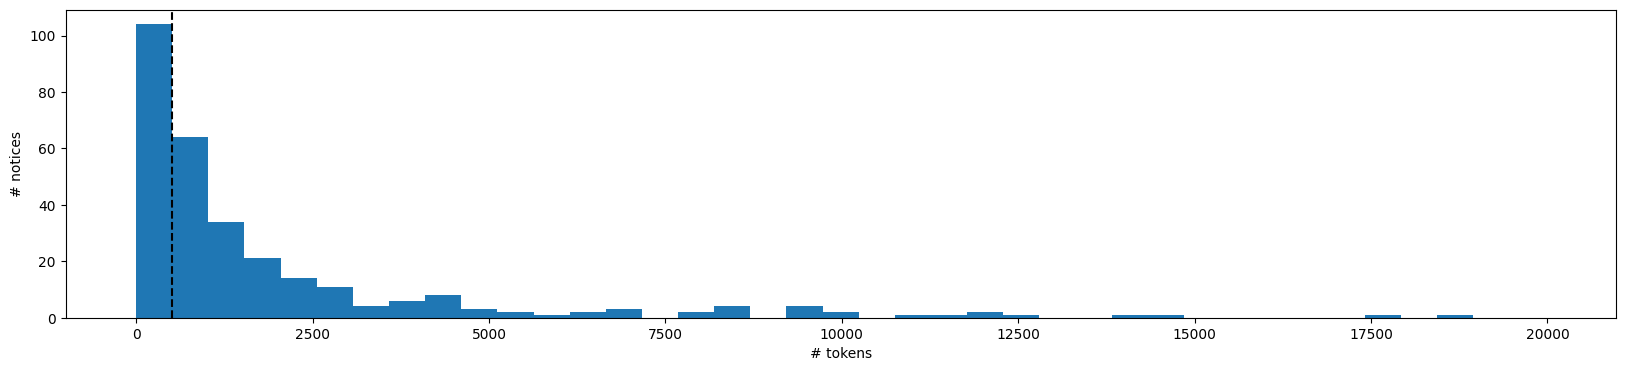

In [11]:
sample_df = bert_train_df.sample(300, random_state=78483)

sample_text = sample_df['joined_text']
n_tokens = np.array([aux.count_tokens(s, bert_tokenizer, max_length=None) for s in sample_text])
pl.figure(figsize=(20,4))
pl.hist(n_tokens, bins=np.arange(0,20000, 512))
pl.xlabel('# tokens')
pl.ylabel('# notices')
pl.axvline(512, color='k', linestyle='--')
pl.show()

As in the bag-of-words model, we will use sample weights during fitting so the model gives more importance to getting the most relevant notices right. 
We will use the weights that were tailored for the bag-of-words model.

In [12]:
def add_sample_weights(features, labels):
    """
    Add weights associated to the data labels. To be used 
    on a tensorflow dataset via the map() method.
    """
    # Create hash table with the (hard-coded) weights:
    weights = {1:1, 2:3, 3:5, 4:10, 5:50}
    table_init = tf.lookup.KeyValueTensorInitializer(keys=list(weights.keys()), values=list(weights.values()), key_dtype=tf.int32, value_dtype=tf.float32)
    table = tf.lookup.StaticHashTable(initializer=table_init, default_value=0.0)
    
    # Set the sample weights:
    sample_weights = table.lookup(tf.cast(labels, tf.int32))
    
    return (features, labels, sample_weights)

The function below:
1. takes the preprocessed notices, tonenizes them (and turn the tokens into indices);
2. crop the index sequence to a maximum length;
3. put the data into batches; 
4. turn them into tensorflow dataset objects; and
5. add the sample weights.

In [13]:
# Transform DataFrame into tokenized Tensorflow datasets, and add sample weights:
train_tfd = ne.process_pandas_to_tfdataset(bert_train_df, bert_tokenizer, max_length=320, text_col='joined_text', target_col='relevancia', batch_size=32, shuffle=True).map(add_sample_weights)
val_tfd   = ne.process_pandas_to_tfdataset(bert_val_df, bert_tokenizer, max_length=320, text_col='joined_text', target_col='relevancia', batch_size=32, shuffle=False).map(add_sample_weights)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/ba]


A tensorflow dataset is a collection of batches of instances. Each instance has three BERT inputs (sequence of token indices, token types, and attention mask); 
a target (the true relevance, used for training); and its weight.

In [14]:
# Example of instance:
for batch in train_tfd.take(1):
    print(batch)

({'input_ids': <tf.Tensor: shape=(32, 320), dtype=int64, numpy=
array([[  101,  2709, 22288, ..., 13778,   117,   102],
       [  101,  4303,   322, ...,     0,     0,     0],
       [  101,  8287,   118, ..., 14556,  6839,   102],
       ...,
       [  101,  4303,   322, ..., 22336,   120,   102],
       [  101,  4303,   322, ...,   150,   117,   102],
       [  101,  8287,  3890, ...,  8504,   125,   102]])>, 'token_type_ids': <tf.Tensor: shape=(32, 320), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(32, 320), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>}, <tf.Tensor: shape=(32,), dtype=float

The datasets above will be used as input and target for the model. Now let's build the model!

### 5.2. Build the model

Neural network models such as BERT use **Gradient Descent** methods to minimize a cost function. When setting up the model, we need to:
* specify the cost function to minimize (the `model_loss` below);
* specify the method for minimizing the cost function (called `optimizer`);
* compile the model with these specifications.

Note that we also froze all layers of the model except for the last (top) one. This is done so, when we begin training the top layer for our 
specific task, we don't screw the bottom layers that were fit on the pretraining. Our strategy will be to first settle down the top layer to 
reasonable coefficients and then train the whole model. At this stage we also specify any metrics we want to apply to the predictions.

In [76]:
# First fit the top layer of the model (bottom layers are frozen):
model_loss = tf.keras.losses.MeanSquaredError()
metrics    = [ne.NDCGMetric(len(train_raw))]
optimizer  = tf.keras.optimizers.Adam(learning_rate=1e-3)
bert_model.get_layer('bert').trainable = False
bert_model.compile(optimizer, model_loss, metrics=metrics, weighted_metrics=[])
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 108,923,905
Trainable params: 769
Non-trainable params: 108,923,136
_________________________________________________________________


Now we fit the model to the data using the gradient descent approach. At each step, the model uses a batch of training data to guess the change it has to apply to is parameters
to reduce the loss function. After one epoch, it has used all the batches. We repeat this process many times until no significant improvement is made.

In [ ]:
# Fitting the model:
history = bert_model.fit(train_tfd, epochs=13, validation_data=val_tfd)

We can save the model with its coefficients as a check point (from where we can restart later on):

In [273]:
# Save the model at this training stage:
#bert_model.save_pretrained('modelos/bertimbau-dou-regressor-w2-m2-checkpoint-01')

Below we see how the loss function is reduced in the training and validation sets as we cycle through the data:

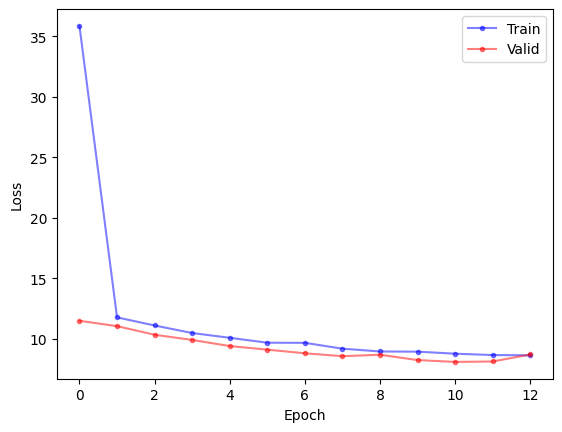

In [284]:
# Plot the model performance vs. epoch:
aux.plot_loss_per_epoch(history)
pl.show()

In [285]:
# Load model checkpoint:
#bert_model = TFAutoModelForSequenceClassification.from_pretrained('modelos/bertimbau-dou-regressor-checkpoint-01')

Now that the top layer has reached more reasonable parameters, we allow for the whole model to be trained. It may be important to reduce the learning rate to avoid overshooting the sweet spot. 

#### **Exercise**: Unfreeze the BERT layers and train it

Make the BERT layers of `bert_model` object trainable. Then, recreate the `optimizer` with a lower learning rate (1e-6) and compile the model in the same way we did above. 
You can print out the summary of the model (using its `summary()` method) as well. Compare the number of trainable parameters in this summary's output with the previous one. 

In [12]:
# Write your solution here:


Now let's fit the model for 2 epochs on the training set `train_tfd`, and use the `val_tfd` as the validation set.

In [12]:
# Write your solution here:


#### **Solution**

In [14]:
# Unfreeze lower layers for training and lower learning rate:
bert_model.get_layer('bert').trainable = True
optimizer  = tf.keras.optimizers.Adam(learning_rate=5e-7)
bert_model.compile(optimizer, model_loss, metrics, weighted_metrics=[])
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 108,923,905
Trainable params: 108,923,905
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Fitting the model:
dump = bert_model.fit(train_tfd, epochs=2, validation_data=val_tfd)

#### Continuing...

Let's resume the training under these new circumstances. At this time, we will use a technique to avoid overfitting called **early stopping**: we will stop making the model better adjusted 
to the training data when its performance on the validation set stops inscreasing.

In [18]:
# Fit the whole model:
metrics[0].reset_state()
early_stopping = tf.keras.callbacks.EarlyStopping('val_nDCG', mode='max', patience=6, restore_best_weights=True)
history = bert_model.fit(train_tfd, epochs=60, validation_data=val_tfd, callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 137s 1s/step - loss: 3.0715 - nDCG: 0.9835 - val_loss: 5.2384 - val_nDCG: 0.9698
Epoch 2/10
125/125 [==============================] - 141s 1s/step - loss: 3.0895 - nDCG: 0.9820 - val_loss: 5.0641 - val_nDCG: 0.9700
Epoch 3/10
125/125 [==============================] - 140s 1s/step - loss: 3.0572 - nDCG: 0.9838 - val_loss: 4.9230 - val_nDCG: 0.9697
Epoch 4/10
125/125 [==============================] - 139s 1s/step - loss: 2.9177 - nDCG: 0.9844 - val_loss: 5.1876 - val_nDCG: 0.9706
Epoch 5/10
125/125 [==============================] - 139s 1s/step - loss: 2.9350 - nDCG: 0.9849 - val_loss: 5.0817 - val_nDCG: 0.9708
Epoch 6/10
125/125 [==============================] - 139s 1s/step - loss: 2.9254 - nDCG: 0.9841 - val_loss: 5.2266 - val_nDCG: 0.9705
Epoch 7/10
125/125 [==============================] - 139s 1s/step - loss: 2.9880 - nDCG: 0.9843 - val_loss: 5.0162 - val_nDCG: 0.9701
Epoch 8/10
125/125 [==============================] - 1

**Best result on the validation set (criterium: nDCG)**
* max_len=512, batch=16 >> loss: 5.9428, nDCG: 0.9679
* max_len=384, batch=32 >> loss: 5.0817, nDCG: 0.9708
* max_len=256, batch=32 >> loss: 5.4849, nDCG: 0.9690
* max_len=128, batch=32 >> loss: 6.0357, nDCG: 0.9596

Save the model for later:

In [25]:
# Save the model at this training stage:
#bert_model.save_pretrained('modelos/bertimbau-dou-regressor-w2-m2-l384-checkpoint-02')

Confirm the performance of the model:

In [21]:
# Confirm that the performance is the lowest in the fit: 
bert_val_pred = bert_model.predict(val_tfd)
aux.my_ndcg(bert_val_df['relevancia'].values, bert_val_pred['logits'][:,0])

25/25 [==============================] - 9s 344ms/step


0.9703881021155609

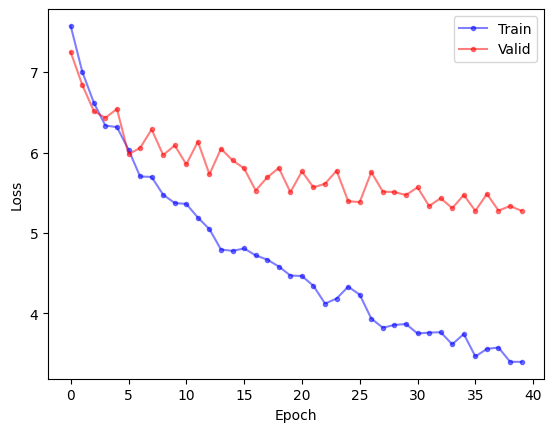

In [262]:
# Plot the loss function achieved after each epoch:
aux.plot_loss_per_epoch(history)

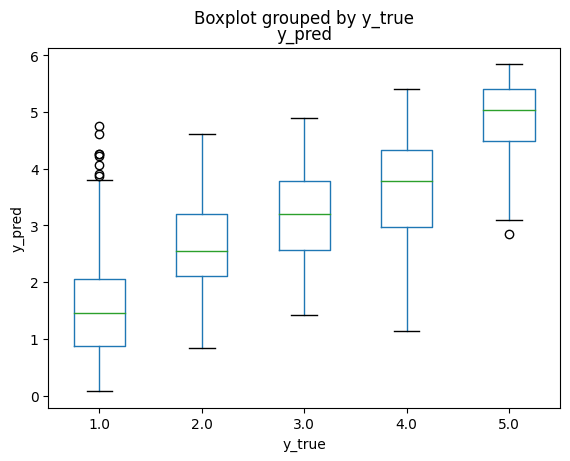

In [24]:
# Box plot of the distribution of predicted relevances per true relevance:
y_pred_true_df = pd.DataFrame({'y_pred':bert_val_pred['logits'][:,0], 'y_true': bert_val_df['relevancia'].values}, index=bert_val_df.index)
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
pl.ylabel('y_pred')
pl.show()

### 5.3. How to try to improve the model (What lies ahead)

Some strategies that could improve the performance:
* inspect the notices that misleads the model to find hints on why it makes mistakes;
* pretrain it to guess masked words and next sentences on the specific domain of DOU notices (unsupervised learning);
* train it to find out the relevance of texts in other domains where you have more labeled data and hope the model transfers this learning;
* add more labeled data and train on it;
* try out other preprocessing.

Note that:

* At some point, we may reach the irreducible error caused by subjective judgement of the relevance of notices. At this point, no improvement can be made.

## 6. Final test and final (production) model

In [40]:
import joblib
from sklearn.base import clone

### 6.1. Final test

Now that we already decided on what model to use, we will measure its performance on the test set:

In [32]:
# Preprocess the test set:
proc_test = preprocessor.transform(test_raw)

# Final evaluation on the test set:
y_pred_test = model.predict(proc_test)
aux.my_ndcg(proc_test['relevancia'], y_pred_test)

0.972029019200547

### 6.2. Building a production model

We can build a production model by fitting it to the whole data, to take advantage of more training data. However, there is no way 
of estimating its performance, so we stick to the estimate above. 

In [41]:
# Add sample weights to test set:
proc_test['weight'] = proc_test['relevancia'].map(weight_mapping)
# Join data:
proc_full = pd.concat([proc_train_val, proc_test], sort=False)

# Fit the model to train and validation:
production_model = clone(model)
dump = production_model.fit(proc_full, proc_full['relevancia'].values, fit__sample_weight=proc_full['weight'])

Now we save the production model to be applied to new, unlabeled data: 

In [ ]:
# Save the model:
dump = joblib.dump(production_model, 'modelos/bow-ridge-production.joblib')

### 6.3. Loading a saved model

When required, we can load the production model. Beware that if you have used custom made transformers (as we did), the code for these transformers must be available to the model as well (that is, it is not saved along with the model).

In [43]:
# Load:
saved_model = joblib.load('modelos/bow-ridge-production.joblib')

Just to check if the model is able to make predictions, let's apply it to the labeled dataset we have. Since the production model usedthe whole data for training,
we expect an almost perfect score (that is, this is not an estimate of the performance of the model on new data): 

In [46]:
# Check the performance on the (now) training data:
y_pred_full = saved_model.predict(proc_full)
aux.my_ndcg(proc_full['relevancia'], y_pred_full)

0.9990107532943943